# Solutions Assignment 2
Author: Luis Denninger, Leon Herbrik

In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

## Models

### Multi-layer Perceptron


In [2]:
class MLP_Classifier(nn.Module):

    def __init__(self,
                    input_dim: int,
                    mlp_layers: list,
                    ):
        """
        Initialization of a multi-layer perceptron.

        Parameters:
            input_dim (int): Size of the input.
            mlp_layers (list): List containing the sizes and types of the mlp layers. Number of elements determines the number of layers.
                Format: 
                    [
                        {
                            'type': 'linear',
                            'dimension': 128
                        },
                        {
                            'type': 'relu',
                            'dimension': 128,
                        }
                        {
                            'type': 'batchnorm',
                            'eps':1e-5,
                            'momentum': 0.1
                        },
                        {
                            'type': 'dropout',
                            'prob': 0.5
                        }
                    ]
            output_dim (int): Size of the output.
        """
        
        super(MLP_Classifier, self).__init__()
        self.build_up_model(input_dim, mlp_layers)

    def build_up_model(self, input_dim: int, mlp_layers: list):
        # Build the model and each layer according to the config
        layers = nn.ModuleList()
        for (i, layer) in enumerate(mlp_layers):
            layer_inp_dim = input_dim if i == 0 else mlp_layers[i-1]['dimension']
            # Add a linear layer with a given activation function
            if layer['type'] == 'linear':
                layers.append(nn.Linear(layer_inp_dim, layer['dimension']))
            elif layer['type'] =='relu':
                layers.append(nn.ReLU())
            elif layer['type'] == 'tanh':
                layers.append(nn.Tanh())
            elif layer['type'] =='sigmoid':
                layers.append(nn.Sigmoid())
            elif layer['type'] == 'elu':
                layers.append(nn.ELU())
            elif layer['type'] =='selu':
                layers.append(nn.SELU())
            elif layer['type'] == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif layer['type'] == 'prelu':
                layers.append(nn.PReLU())
            elif layer['type'] == 'softmax':
                layers.append(nn.Softmax(dim=-1))
            elif layer['type'] =='batchnorm':
                layers.append(nn.BatchNorm1d(layer_inp_dim, layer['eps'], layer['momentum']))
            elif layer['type'] == 'dropout':
                layers.append(nn.Dropout(layer['prob']))
            elif layer['type'] == 'flatten':
                layers.append(nn.Flatten())
            
        self.model = nn.Sequential(*layers)
            

    
    def forward(self, x):
        return self.model(x)
    

def build_model(config: dict):
    # Build the model from the given config
    # Since the above model was taken from a broader framework that has more flexibility, we have to convert our simpler config file
    layer_config = []
    for layer in config['layers']:
        # Add each layer
        if type(layer) == int:
            layer_config.append({
                'type': 'linear',
                'activation': config['activation'],
                'dimension': layer})
        else:
            if layer == 'batchnorm':
                layer_config.append({
                    'type': 'batchnorm',
                    'dimension': layer_config[-1]['dimension'],
                    'eps': 1.0e-05,
                    'momentum': 0.1})
            if layer == 'dropout':
            # Add dropout layers in between if wanted
                layer_config.append({
                    'type': 'dropout',
                    'dimension': layer_config[-1]['dimension'],
                    'prob': 0.5})
    # Append final output layer
    layer_config.append({'type': 'linear',
            'activation': 'softmax',
            'dimension': config['output_dim']})
    
    model = MLP_Classifier(config['input_dim'], layer_config)

    return model

### Convolutional Neural Network

In [76]:

class ConvolutionalNN(nn.Module):
    
    def __init__(self, 
                    layers: list,):
        """
            Convolutional Neural Network. The layers are fully configurable by providing a simple config for each layer

            Parameters:
                layers (list): list of layers to be configured
                    Format:
                            [
                                {
                                    "type": "conv2d",
                                    "in_channels": 1,
                                    "out_channels": 1,
                                    "kernel_size": (3,3),
                                    "stride": (1,1),
                                }, 
                                {
                                    "type": "relu"
                                },
                                {
                                    "type": "maxpool2d",
                                    "kernel_size": (2,2)
                                },
                                {
                                    "type": "avgpool2d",
                                    "kernel_size": (2,2)
                                },
                                {
                                    "type": "linear",
                                    "in_features": 512,
                                    "out_features": 10
                                }
        """

        super(ConvolutionalNN, self).__init__()

        self.build_model(layers)


    def build_model(self, layer_config):
        layers = nn.ModuleList()
        for (i, layer) in enumerate(layer_config):
            if layer["type"] == "conv2d":
                layers.append(nn.Conv2d(layer["in_channels"], layer["out_channels"], layer["kernel_size"], layer["stride"]))
            elif layer["type"] == "relu":
                layers.append(nn.ReLU())
            elif layer["type"] == "softmax":
                layers.append(nn.Softmax(dim=-1))
            elif layer["type"] == "maxpool2d":
                layers.append(nn.MaxPool2d(layer["kernel_size"], layer['stride']))
            elif layer["type"] == "avgpool2d":
                layers.append(nn.AvgPool2d(layer["kernel_size"], layer['stride']))
            # Add a linear layer with a given activation function
            elif layer['type'] == 'linear':
                layers.append(nn.Linear(in_features=layer['in_features'], out_features=layer['out_features']))
            elif layer['type'] =='batchnorm2d':
                layers.append(nn.BatchNorm2d(layer['num_features'], layer['eps'], layer['momentum']))
            elif layer['type'] =='batchnorm1d':
                layers.append(nn.BatchNorm1d(layer['num_features'], layer['eps'], layer['momentum']))
            elif layer['type'] == 'dropout':
                layers.append(nn.Dropout(layer['prob']))
            elif layer['type'] == 'flatten':
                layers.append(nn.Flatten())
            
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.model(x)
        return x
        
        

## Data

In [4]:
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=False, transform=transforms.ToTensor(), download=True)


def load_data(config):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    return train_loader, test_loader

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 60000
Test dataset size: 10000


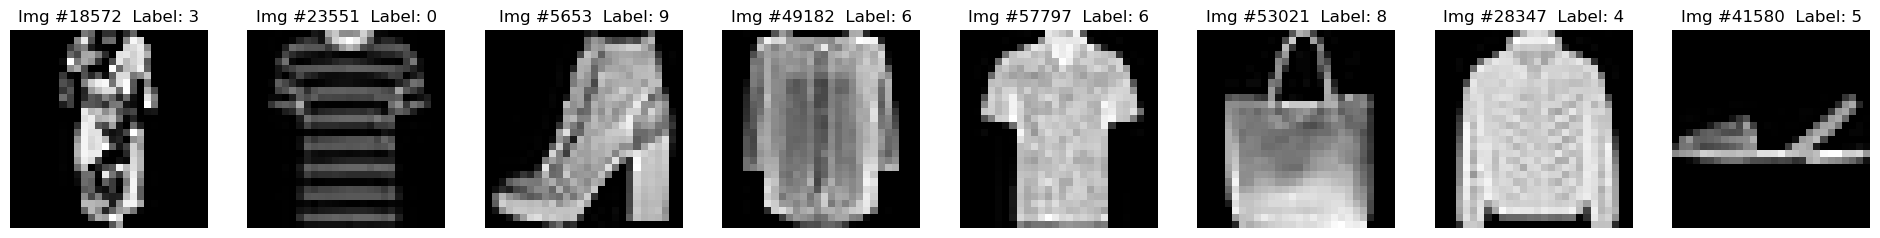

In [5]:
###--- Visualize Training Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    label = train_dataset[n][1]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")


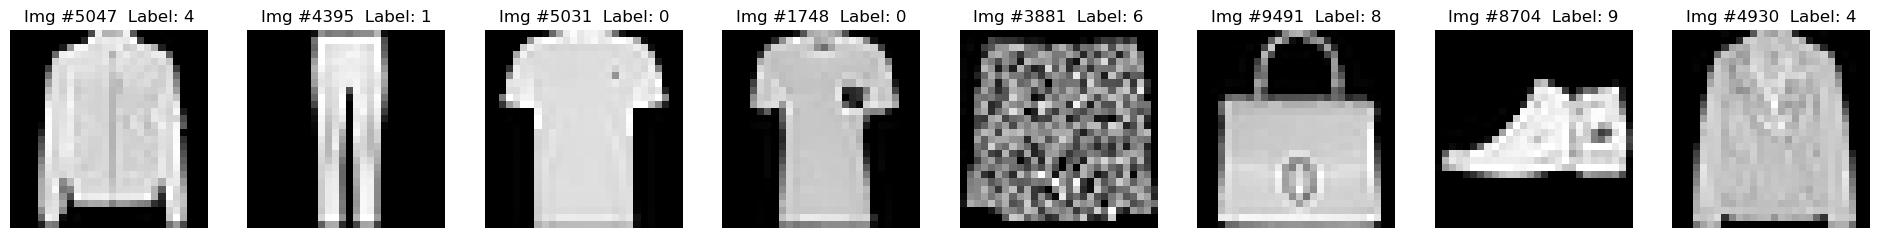

In [6]:
###--- Visualize Evaluation Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(test_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = test_dataset[n][0].permute(1,2,0)
    label = test_dataset[n][1]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

## Scripts/Functions

### Logging

In [7]:
###--- Training/Evaluation Logger ---###
# This module is used to log and then retrive the data for visualization etc.

class Logger():
    def __init__(self,
                exp_name: str = None,
                    run_name: str = None,
                        base_dir: str = None,
                            model_config: dict = None,
                                writer: SummaryWriter = None,
                                    save_external: bool = True,                                    
                                    save_internal: bool = False, 
                                ):
        
        ### Run Information ###
        
        self.exp_name = exp_name
        self.run_name = run_name

        if save_external:
            assert base_dir is not None and exp_name is not None and run_name is not None, 'Please provide exp.-, run name and base_dir.'
            self.writer = SummaryWriter(str(self.run_dir/"logs")) if writer is None else writer

        self.model_config = model_config

        self.save_internal = save_internal
        self.save_external = save_external
        self._internal_log = {}

        self.log_gradients = False

        
        
    def log_data(self, epoch: int, data: dict,  iteration: int=None):
        """
            Log the data.
            Arguments:
                epoch (int): The current epoch. 
                data (dict): The data to log.
                    Format:
                            {
                                [name]: value,
                                ...
                            }
        
        """
        if self.save_external:
            
            for key, value in data.items():
                if type(value) == list:
                    prefix_name = f'iteration_metrics/'
                    log_iter = self.model_config['num_iterations']*(epoch-1)
                    for i, item in enumerate(value):
                        self.writer.add_scalar(prefix_name + key, item, log_iter + i +1)
                    continue
                prefix_name = f'epoch_metrics/' if iteration is None else f'iteration_metrics/'
                log_iter = epoch if iteration is None else (self.model_config['num_iterations']*(epoch-1) + iteration)
                self.writer.add_scalar(prefix_name + key, value, log_iter)
            
        if self.save_internal:
            self._save_internal(data)
    
    def get_log(self):
        return self._internal_log

    def get_last_log(self):
        last_log = {}
        for key in self._internal_log.keys():
            last_log[key] = self._internal_log[key][-1]
        return last_log

    def enable_internal_log(self):
        self.save_internal = True
    
    def disable_internal_log(self):
        self.save_internal = False

    
    def _save_internal(self, data):
        for key, value in data.items():
            if not key in self._internal_log.keys():
                self._internal_log[key] = []
            if type(value) == list:
                self._internal_log[key] += value
                continue
            self._internal_log[key].append(value)

In [8]:
###--- Debugger?Extensive Logging Module ---###

# This modules is hooked into arbitrary layers of a PyTorch model to log data in the forward or backward pass.
# It can be used to set breakpoints and read out the weights for each forward pass.

class InspectorGadgets():
    """
        Module that encapsulates different functions to investigate everything going on withing a Pytorch module.
        Each logging function creates a hook on the forward or backward pass of the given layers.
        Currently multiple hooks are potentially acquired for a single layer pass which might cause an overhead.

    """
    def __init__(self):
        
        self._layer_output = {}
        self._gradient_input = {}
        self._gradient_output = {}
        self._weights = {}
        self._bias = {}

        self._layers_to_inspect = {}

        self._hooks = {}
        self._active_hooks = {}
        self._inspect_once = False
    
    def inspect_once(self):
        """
            The inspector only hooks onto the model once and then removes all hooks
        """
        self._inspect_once = True
        self._activate_all()

    def inspect(self):
        self._inspect_once = False
        self._activate_all()

    
    def log_outputs(self, layers: list, names: list):
        """
            Log the output of a layer in each forward pass.
            Arguments:
                layers (list[torch.nn.Module]): The layers to log the output of.
                names (list[str]): The names of the layers to log the output of.
        """
        assert len(layers)==len(names), f'Number of layers ({len(layers)}) and names ({len(names)}) must be the same...'


        for i,name in enumerate(names):
            self._layer_output[name] = []

        self._setup_hook(layers, names, 'output_hook')

    def log_weights(self, layers:list, names: list, log_once=False):
        """
            Log the weights of a layer in each forward pass.
            Arguments:
                layers (list[torch.nn.Module]): The layers to log the output of.
                names (list[str]): The names of the layers to log the output of.
        """
        assert len(layers)==len(names), f'Number of layers ({len(layers)}) and names ({len(names)}) must be the same...'

        self.log_weights_once = log_once
        for i,name in enumerate(names):
            self._weights[name] = []
            self._bias[name] = []


        self._setup_hook(layers, names, 'weight_hook')

    def log_gradients(self, layers: list, names: list):
        """
            Log the gradients in the backward pass of the model.
            Arguments:
                layers (list[torch.nn.Module]): The layers to log the output of.
                names (list[str]): The names of the layers to log the output of.
        """

        assert len(layers)==len(names), f'Number of layers ({len(layers)}) and names ({len(names)}) must be the same...'

        for i,name in enumerate(names):

            self._gradient_output[name] = []

        self._setup_hook(layers, names, 'gradient_hook', forward=False, backward=True)


    def set_breakpoint(self, layers: list, names: list, forward=True, backward=False):
        """
            Set a breakpoint using the ipdb debugger after a specific layer in the forward and/or backward pass.
            Arguments:
                layers (list[torch.nn.Module]): The layers to set breakpoints after.
                names (list[str]): The names of the layers.
                forward (bool): Whether to put breakpoints in the forward pass.
                backward (bool): Whether to put breakpoints in the backward pass.
            
        """
        assert len(layers)==len(names), f'Number of layers ({len(layers)}) and names ({len(names)}) must be the same...'

        self._setup_hook(layers, names, 'break_hook', forward=forward, backward=backward)

    def get_weights(self, name=None):
        if name is None:
            return self._weights, self._bias
        if name in self._weights.keys():
            return self._weights[name], self._bias[name]
        else:
            print(f'Weights not logged for layer {name}')
    
    def get_gradients(self, name=None):
        if name is None:
            return self._gradient_output, self._bias
        if name in self._gradient_output.keys():
            return self._gradient_output[name], self._bias[name]
        else:
            print(f'Gradients not logged for layer {name}')

    def get_output(self, name=None):
        if name is None:
            return self._layer_output
        if name in self._layer_output.keys():
            return self._layer_output[name]
        else:
            print(f'Output not logged for layer {name}')
    
    def _setup_hook(self, layers, names, hook: str, forward=True, backward=False):
        """
            Setup a forward and/or backward hook in the model given the layers and their names from the model.
        
        """
        
        for (i, name) in enumerate(names):

            if not name in self._layers_to_inspect.keys():
                self._layers_to_inspect[name] = layers[i]

            if not name in self._hooks.keys():
                self._hooks[name] = {}
            
            if forward:
                hook_key = ('' if hook!='break_hook' else 'forward_')+ hook
                hook_func = '_' + hook_key
                self._hooks[name][hook_key] = layers[i].register_forward_hook(self._hook_wrapper(name=name, hook=hook_func))
            if backward:
                hook_key = ('' if hook!='break_hook' else 'backward_')+ hook
                hook_func = '_' + hook_key
                self._hooks[name][hook_key] = layers[i].register_full_backward_hook(self._hook_wrapper(name=name, hook=hook_func))

    
    def _remove_hook(self, name, hook):
        """
            Remove a hook by giving the layer name and the hook to remove.
        """
        if not name in self._hooks.keys():
            print(f'Layer {hook} not found for any actions')
            return
        if not hook in self._hooks[name].keys():
            print(f'No hook {hook} set up for layer {name}')
            return

        self._hooks[name][hook].remove()
        self._hooks[name][hook] = None

    def _activate_all(self):
        for layer_name, hooks in self._hooks.items():
            for hook_name, hook in hooks.items():
                if hook is None:
                    self._activate_hook(layer_name, hook_name)

    def _activate_hook(self, name, hook):

        if not name in self._hooks.keys():
            print(f'Layer {hook} not found for any actions')
            return
        if not hook in self._hooks[name].keys():
            print(f'No existing hook {hook} set up for layer {name}')
            return
        
        if self._hooks[name][hook] is None:
            layer = self._layers_to_inspect[name]
            self._attach(name, layer, hook)

    def _hook_wrapper(self, name, hook):
        """
            Wrapper function for the different hooks that can be set in the model. 
            The function mainly serves the purpose to determine which layer of the model triggered the hook function.
        """

        def _gradient_hook(module, grad_input, grad_output) -> None:
            if grad_input[0] is not None:
                self._gradient_input[name].append(grad_input[0].cpu().detach())
            self._gradient_output[name].append(grad_output[0].cpu().detach())
            if self._inspect_once:
                self._remove_hook([name], 'gradient_hook')


        def _forward_break_hook(module, input, output) -> None:
            print(f'Module {name}: '+module.__class__.__name__)
            print(f'Input Shape: {input[0].shape}')
            print(f'Output Shape: {output.shape}')
            ipdb.set_trace()
            if self._inspect_once:
                self._remove_hook([name], 'forward_break_hook')
        
        def _backward_break_hook(module,  grad_input, grad_output) -> None:
            ipdb.set_trace()
            print(f'Grad Input Shape: {grad_input[0].shape}')
            print(f'Grad Output Shape: {grad_output[0].shape}')
            print(f'Grad Module {name}:\n'+module)
            ipdb.set_trace()
            if self._inspect_once:
                self._remove_hook([name], 'backward_break_hook')

        def _output_hook(module, input, output) -> None:
            self._layer_output[name].append(output.cpu().detach())

            if self._inspect_once:
                self._remove_hook([name], 'output_hook')

        def _weight_hook(module, input, output) -> None:
            try:
                self._weights[name].append(module.weight.cpu().detach())
                self._bias[name].append(module.bias.cpu().detach())
            except:
                print(f'Layer {name} has no weights...  ')

            if self._inspect_once:
                self._remove_hook([name], 'weight_hook')
        local_vars = inspect.currentframe().f_locals
        return local_vars[hook]

    def _attach(self, name, layer, hook):
        if hook in ['gradient_hook','backward_break_hook']:
            self._hooks[name][hook] = layer.register_full_backward_hook(self._hook_wrapper(name=name, hook=('_'+hook)))
        else:
            self._hooks[name][hook] = layer.register_forward_hook(self._hook_wrapper(name=name, hook=('_'+hook)))


### Helper Functions

In [9]:
###--- Helper Functions ---###
##---> They are just here to make our life easier

###--- Initialization ---###
def initialize_optimizer(model: torch.nn.Module, config: dict):
    """
        Initialize optimizer.

        Arguments:
            model (torch.nn.Module): Model to be optimized.
            config (dict): Optimizer configuration dictionary.
          
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        
    return optimizer

def initialize_loss( config: dict):
    """
        Initialize criterion.

        Arguments:
            config (dict): Criterion configuration dictionary.
                Format:
                     
    """
    criterion = torch.nn.CrossEntropyLoss()

    return criterion

###--- Random Seed ---###
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

###--- Curver Smoothing ---###
# Taken from session 1 to smooth the curves
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

###--- Model Architecture ---###
def count_model_params(model, verbose=False):
    """Get the layers with trainable parameters and the number of trainable parameters."""
    layer_parameter_number = {}
    for p in model.named_parameters():
        if p.requires_grad:
            layer_parameter_number[p[0]] = p[1].numel()
    layer_parameter_number['total'] = sum(layer_parameter_number.values())
    return layer_parameter_number

def compute_flops(model, dummy_input, verbose=True, detailed=False):
    """ Computing the number of activations and flops in a forward pass """

    # benchmarking
    fca = FlopCountAnalysis(model, dummy_input)
    act = ActivationCountAnalysis(model, dummy_input)
    
    total_flops = fca.total()
    total_act = act.total()

    return total_flops, total_act

def check_configuration(layer_config, ind=None, padding=0, input_shape=(1,28,28), suppress_output=False, fix=False):
    """
        Simple function to inspect the output dimension of each layer of a CNN or MLP given a layer configuration.
        If the layer_configuration is not possible, whether output and input shape do not fit or the output dimensions are non-sense,
        the function returns the output dimension of each layer of to the point of failure and returns a False flag indicating a non-possible architecture.

        Arguments:
            layer_config (list): Model architecture configuration according to our convention.
            ind (int): Index of the layer to get the output dimension from.
            padding (int): Amount of padding to add to the input shape.
            input_shape (tuple): Shape of the input image.
            suppress_output (bool): Whether to suppress the print output for further inspection.

        Returns: List of output dimensions, Bool indicating a possible architecture
    
    """


    def _print_dims(message=None):
        if len(shapes)==len(layer_config)+1:
            print(f'--SUCCESS')
            print(message)
        else:
            print(f'--FAILURE: Layer {len(shapes)}:\t'+message)
        print(f'\n---Model Architecture---')
        print(f'Input Shape: \t{shapes[0]}')
        print('\n'.join(['Layer \t{}: \tType: \t{}:    \tShape: \t{}'.format(k-1,layer_config[k-1]['type'], shapes[k]) for k in range(1, len(shapes))]))
        print(f'Output Shape: \t{shapes[-1]}')

    shapes = [input_shape]
    for i, layer in enumerate(layer_config):
        shape = shapes[-1]
        if any(dim <=0 for dim in (shape if type(shape)==tuple else [shape])):
            if not suppress_output:
                _print_dims(f'Architecture is not possible with shape {shape} after layer {i-1}')
            return shapes, False

        if ind is not None and i-1 == ind:
            return shape, True
        
        if layer['type'] == 'conv2d':
            if len(shape) == 2:
                shape = (1, shape[0], shape[1])
            if shape[1]+padding<layer['kernel_size'][0] or shape[2]+padding<layer['kernel_size'][1]:
                if not suppress_output:
                    _print_dims(f'Kernel of size {layer["kernel_size"]} is larger than input shape {shape}')
                return shapes, False
            if shape[0]!=layer['in_channels']:
                if fix:
                    if not suppress_output:
                        print(f'Layer {i} input channel {layer["in_channels"]} != Input channel {shape}. Fixing...')
                    layer['in_channels'] = shape[0]
                    return check_configuration(layer_config, ind, padding, input_shape, suppress_output, fix)
                else:
                    if not suppress_output:
                        _print_dims(f'Channel size of input {shape[0]} differs from layer input channel size {layer["in_channels"]}')
                    return shapes, False
                
            channel = layer['out_channels']
            height = int(np.floor(float(shape[1] - layer['kernel_size'][0] + 2 * padding) / float(layer['stride'][0]))) + 1
            width = int(np.floor(float(shape[2] - layer['kernel_size'][1] + 2 * padding) / float(layer['stride'][1]))) + 1
            shape = (channel, height, width)

        elif layer['type'] in ['avgpool2d', 'maxpool2d']:
            if len(shape) == 2:
                shape = (1, shape[0], shape[1])
            if shape[1]+padding<layer['kernel_size'][0] or shape[2]+padding<layer['kernel_size'][1]:
                if not suppress_output:
                    _print_dims(f'Pool size {layer["kernel_size"]} is larger than input shape {shape}')
                return shapes, False

            height = int((shape[1] - layer['kernel_size'][0]) / layer['stride'][0] + 1)
            width = int((shape[2] - layer['kernel_size'][1]) / layer['stride'][1] + 1)
            shape = (shape[0], height, width)

        elif layer['type']=='flatten':
            if type(shape)==tuple:
                f = shape[0]
                for k in range(1, len(shape)):
                    f *= shape[k]
                shape = f
        
        elif layer['type'] == 'linear':
            if type(shape) == tuple:
                if not suppress_output:
                    _print_dims(f'Linear layer received input of dimension {shape}')
                return shapes, False
            if shape!= layer['in_features']:
                if fix:
                    if not suppress_output:
                        print(f'Layer {i} input features {layer["in_features"]} != Input features {shape}. Fixing...')
                    layer['in_features'] = shape
                    return check_configuration(layer_config, ind, padding, input_shape, suppress_output, fix)
                if not suppress_output:
                    _print_dims('Linear layer received input of size {} instead of {}'.format(shape, layer['in_features']))
                return shapes, False
            shape = layer['out_features']
    
        shapes.append(shape)
    if not suppress_output:
        _print_dims()

    if fix:
        return (layer_config, shapes), True
    return shapes, True



### Data Augmentation and Preprocessing

In [10]:
"""
    Data Augmentation Module:
        Data augmentation steps are provided as a list of dictionaries. Each dictionary is a description of a data augmentation step.
        The possible keys are:
            {'type': 'flatten', 'train': True, 'eval': True},
            {'type': 'rgb2gray', 'train': True, 'eval': True},
            {'type': 'normalize', 'train': True, 'eval': True},
            {'type': 'permute', 'train': True, 'eval': True},
            {'type': 'rotate', 'degrees': 90, 'train': True, 'eval': True},
            {'type': 'resize', 'size': (height, width), 'train': True, 'eval': True},
            {'type': 'random_rotation', 'degrees': 90, 'train': True, 'eval': True},
            {'type': 'random_crop', 'size': (height, width), 'train': True, 'eval': True},
            {'type': 'random_horizontal_flip', 'p': 0.5, 'train': True, 'eval': True},
            {'type': 'random_erase', 'probability': 0.5, 'scale': (0.01,0.2), 'train': True, 'eval': True},

"""

class ImageDataAugmentor:
    """
        Module to apply pre-defined data augmentations.
    
    """

    def __init__(self, config: list):
        self.config = config

        self._init_pipeline()

    def __call__(self, image, train=True):
        return self.train_pipeline(image) if train else self.eval_pipeline(image)
    
    def processing_pipeline(self, *funcs):
        """
            Returns a function that applies a sequence of data augmentation steps in a pipeline.
        """
        return lambda x: reduce(lambda acc, f: f(acc), funcs, x)
    
    ## Processing Functions ##    
    def _flatten_img(self, input: torch.Tensor):
        # Flatten only the image size dimensions
        if self.flatten_only_img_size:
            return torch.flatten(input, start_dim=-2)
    
        # Flatten all dimensions except of the batch dimension
        else:
            return torch.flatten(input, start_dim=1)

    def _rgb2grayscale(self, input: torch.Tensor):
        return tv.transforms.Grayscale()(input)
    
    def _normalize(self, input: torch.Tensor):
        return tv.transforms.Normalize(mean=[0.485], std=[0.229])(input)
    
    def _permute(self, input: torch.Tensor):
        if len(input.shape) == 4 and len(self.permute_dim.shape)==3:
            p_dim = (0, self.permute_dim[0], self.permute_dim[1], self.permute_dim[2])
            return input.permute(p_dim)
        return input.permute(self.permute_dim)
    
    def _resize(self, input: torch.Tensor):
        return tv.transforms.Resize(self.resize_size)(input)
    
    def _random_rotation(self, input: torch.Tensor):
        return tv.transforms.RandomRotation(degrees=self.random_rotation_degrees)(input)
    
    def _gaussian_blur(self, input: torch.Tensor):
        return tv.transforms.GaussianBlur(kernel_size=self.blur_kernel_size, sigma = self.blur_sigma)(input)

    def _random_erase(self, input: torch.Tensor):
        return tv.transforms.RandomErasing(p=self.random_erase_probability, scale=self.random_erase_scale)(input)
    
    def _random_color_jitter(self, input: torch.Tensor):
        return tv.transforms.ColorJitter(self.jitter_brightness, self.jitter_contrast, self.jitter_saturation, self.jitter_hue)(input)
    
    def _adjust_brightness(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_brightness(input, self.brightness_factor)
    
    def _adjust_contrast(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_contrast(input, self.contrast_factor)
    
    def _adjust_saturation(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_saturation(input, self.saturation_factor)
    
    def _adjust_hue(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_hue(input, self.hue_factor)
    
    def _adjust_gamma(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_gamma(input, self.gamma_factor)
    
    def _adjust_sharpness(self, input: torch.Tensor):
        return tv.transforms.functional.adjust_sharpness(input, self.sharpness_factor)
    
    def _squeeze(self, input: torch.Tensor):
        if self.squeeze_dim is not None:
            return input.squeeze(dim=self.squeeze_dim)
        return input.squeeze()
    
    def _init_pipeline(self):
        train_augmentation = []
        eval_augmentation = []
        for process_step in self.config:
            if process_step['type'] == 'flatten_img':
                if process_step['train']:
                    train_augmentation.append(self._flatten_img)
                if process_step['eval']:
                    eval_augmentation.append(self._flatten_img)
            elif process_step['type'] == 'rgb2gray':
                if process_step['train']:
                    train_augmentation.append(self._rgb2grayscale)
                if process_step['eval']:
                    eval_augmentation.append(self._rgb2grayscale)
            elif process_step['type'] == 'normalize':
                if process_step['train']:
                    train_augmentation.append(self._normalize)
                if process_step['eval']:
                    eval_augmentation.append(self._normalize)
            elif process_step['type'] == 'permute':
                self.permute_dim = process_step['dim']
                if process_step['train']:
                    train_augmentation.append(self._permute)
                if process_step['eval']:
                    eval_augmentation.append(self._permute)
            elif process_step['type'] =='resize':
                self.resize_size = process_step['size']
                if process_step['train']:
                    train_augmentation.append(self._resize)
                if process_step['eval']:
                    eval_augmentation.append(self._resize)
            elif process_step['type'] == 'random_rotation':
                self.random_rotation_degrees = process_step['degrees']
                if process_step['train']:
                    train_augmentation.append(self._random_rotation)
                if process_step['eval']:
                    eval_augmentation.append(self._random_rotation)
            elif process_step['type'] == 'gaussian_blur':
                self.blur_kernel_size = process_step['kernel_size']
                self.blur_sigma = process_step['sigma']
                if process_step['train']:
                    train_augmentation.append(self._gaussian_blur)
                if process_step['eval']:
                    eval_augmentation.append(self._gaussian_blur)
            elif process_step['type'] == 'random_erase':
                self.random_erase_probability = process_step['probability']
                self.random_erase_scale = process_step['scale']
                if process_step['train']:
                    train_augmentation.append(self._random_erase)
                if process_step['eval']:
                    eval_augmentation.append(self._random_erase)
            elif process_step['type'] == 'adjust_brightness':
                self.brightness_factor = process_step['factor']
                if process_step['train']:
                    train_augmentation.append(self._adjust_brightness)
                if process_step['eval']:
                    eval_augmentation.append(self._adjust_brightness)
            elif process_step['type'] == 'adjust_contrast':
                self.contrast_factor = process_step['factor']
                if process_step['train']:
                    train_augmentation.append(self._adjust_contrast)
                if process_step['eval']:
                    eval_augmentation.append(self._adjust_contrast)
            elif process_step['type'] == 'adjust_saturation':
                self.saturation_factor = process_step['factor']
                if process_step['train']:
                    train_augmentation.append(self._adjust_saturation)
                if process_step['eval']:
                    eval_augmentation.append(self._adjust_saturation)
            elif process_step['type'] == 'adjust_hue':
                self.hue_factor = process_step['factor']
                if process_step['train']:
                    train_augmentation.append(self._adjust_hue)
                if process_step['eval']:
                    eval_augmentation.append(self._adjust_hue)
            elif process_step['type'] == 'adjust_gamma':
                self.gamma_factor = process_step['factor']
                if process_step['train']:
                    train_augmentation.append(self._adjust_gamma)
                if process_step['eval']:
                    eval_augmentation.append(self._adjust_gamma)
            elif process_step['type'] == 'color_jitter':
                self.jitter_brightness = process_step['brightness']
                self.jitter_contrast = process_step['contrast']
                self.jitter_saturation = process_step['saturation']
                self.jitter_hue = process_step['hue']
                if process_step['train']:
                    train_augmentation.append(self._random_color_jitter)
                if process_step['eval']:
                    eval_augmentation.append(self._random_color_jitter)
            elif process_step['type'] =='squeeze':
                self.squeeze_dim = process_step['dim']
                if process_step['train']:
                    train_augmentation.append(self._squeeze)
                if process_step['eval']:
                    eval_augmentation.append(self._squeeze)

        self.train_pipeline = self.processing_pipeline(*train_augmentation)
        self.eval_pipeline = self.processing_pipeline(*eval_augmentation)
    

### Visualization

In [11]:
def visualize_training_results(logger: Logger, config: dict):

    iteration_corrected = [np.sum(np.arange(i)*config['num_iterations']) for i in range(config['num_epochs']+1)]

    # Load the data from the MLP training
    data = logger.get_log()

    train_loss = data['train_loss']
    train_acc = data['train_accuracy']
    eval_loss = data['eval_loss']
    eval_acc = data['accuracy']


    fig = plt.figure(figsize=(14,10))

    smooth_loss = smooth(train_loss, 31)
    ax1 = fig.add_subplot(221)
    ax1.plot(train_loss, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
    ax1.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
    ax1.set_xlabel("# Iteration")
    ax1.set_ylabel("CrossEntropy Loss")
    ax1.set_title('Training Loss')

    ax2 = fig.add_subplot(222)
    ax2.plot(iteration_corrected, eval_loss, c="red", label="Evaluation Loss", linewidth=3)
    ax2.set_xlabel("# Iteration")
    ax2.set_ylabel("CrossEntropy Loss")
    ax2.set_title('Evaluation Loss')


    smooth_acc = smooth(train_acc, 31)
    ax3 = fig.add_subplot(223)
    ax3.plot(train_acc, c="blue", label="Training Accuracy", linewidth=3, alpha=0.5)
    ax3.plot(smooth_acc, c="red", label="Smoothed Accuracy", linewidth=3)
    ax3.set_ylim(0.0,1.0)
    ax3.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax3.set_xlabel("# Iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_title('Training Accuracy')

    ax4 = fig.add_subplot(224)
    ax4.plot(iteration_corrected, eval_acc, c="red", label='Evaluation Accuracy', linewidth=3)
    ax4.set_xlabel("# Iteration")
    ax4.set_ylabel("Accuracy")
    ax4.set_ylim(0.0,1.0)
    ax4.set_yticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax4.set_title('Evaluation Accuracy')


def visualize_confusion_matrix(confusion_matrix):
    plt.figure(figsize = (12,7))
    sn.heatmap(confusion_matrix[0], annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def visualize_convolution(image, kernels, outputs, layer_names, layer_types=None, random=True, num_kernels=5):
    """
        Visualization of the kernels and the output of the convolution layer for the given kernel. 
        Row-wise different kernels for the given image are visualized in random order or in order of the kernels within the model.
        If there are multiple input channels in a layer a subset of the kernels for each input dimension are visualized.

        Note: The visualization is not complete yet. It does not included biases and has spacing issues.
            But for now it is sufficient to reason about specific kernels, especially in the first layer, and the extracted features
    
    """
    assert num_kernels <= kernels[0].shape[0]

    # Spacing parameters
    image_size = 5.0
    output_size = 3.0
    kernel_layout = (6,3)
    num_layers = len(kernels)
    num_col = 3*num_layers+1
    width_ratio = np.ones(num_col).tolist()
    height_ratio = (10*np.ones(num_kernels+1)).tolist()
    height_ratio[0] = 2
    kernel_annot = (2,-10)

    image = image.numpy()

    # Define figure and grid to hold the visualizations of each grid
    fig = plt.figure(figsize=(30,15))
    figure_grid = GridSpec(num_kernels+1, num_col, figure=fig, width_ratios=width_ratio, height_ratios=height_ratio)

    # Define random indices for the choice of the kernels to visualize
    if random:
        random_inds = []
        for i in range(num_layers):
            random_inds.append(np.arange(kernels[i].shape[0]))
            np.random.shuffle(random_inds[-1])
    # Visualize the image
    ax = fig.add_subplot(figure_grid[:,0])
    im = ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title('Input Image')
    # Set the colorbar
    cbar_ax = fig.add_axes([0.02, 0, 0.12, 0.01])
    cbar = fig.colorbar(im,cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    # Set the titles for each layer column
    for i in range(num_layers):
        module_plot = fig.add_subplot(figure_grid[0,(1+i):(i+2)])
        module_plot.axis('off')
        in_channel = len(kernels[i][0].shape) if len(kernels[i][0].shape)==3 else 1
        out_channel = kernels[i].shape[0]
        label = f'Type: {layer_names[i]}\n' if layer_names is not None else ''
        label += f"In Channels: {in_channel}\nOut Channels: {out_channel}"
        module_plot.set_title(f'Layer {layer_names[i][-1]}')
        module_plot.annotate(label, (0.1,0.5), xycoords='axes fraction', va='center')

    # Create the visualizations of the kernels of each layer and stack them into the grid
    print_rows = np.arange(0,num_kernels)        
    for i in print_rows:
        for k in range(1,num_layers+1):
            # Get the kernel
            kernel_ind = random_inds[k-1][i] if random else i
            kernel = kernels[k-1][kernel_ind].numpy()
            # Create plot to hold the visualization of the kernel and output
            layer_plot = figure_grid[i+1,k].subgridspec(1,2, wspace=0.02)
            # If we have multiple input channels, visualize multiple kernels for the input dimension
            if len(kernel.shape)==3:
                # Create a grid of size kernel_layout
                kernel_layer_plot = layer_plot[0,0].subgridspec(kernel_layout[0],kernel_layout[1], wspace=0.1, hspace=0.0)
                num_kernels = kernel.shape[0]
                k_ind = 0
                # Fill each grid cell with a kernel
                for i_k in range(kernel_layout[0]):
                    for j_k in range(kernel_layout[1]):
                        if k_ind == num_kernels:
                            break
                        # Visualize a kernel
                        ax1 = fig.add_subplot(kernel_layer_plot[i_k,j_k])
                        # Normalize to [0,1] 
                        kernel_mat = (kernel[k_ind] - kernel[k_ind] .min()) / (kernel[k_ind] .max() - kernel[k_ind] .min())
                        ax1.imshow(kernel_mat,  cmap='gray')
                        ax1.axis('off')
                        k_ind += 1
                    if k_ind == num_kernels:
                            break
                ax1 = fig.add_subplot(kernel_layer_plot[:,:])
                ax1.axis('off')
                label = f'kernel index: {kernel_ind}'
                ax1.annotate(label, kernel_annot, xycoords='axes pixels', fontsize=8)

            else:
                # Just visualize a single kernel
                ax1 = fig.add_subplot(layer_plot[0,0])
                kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
                ax1.imshow(kernel,  cmap='gray')
                ax1.set_xticks([])
                ax1.set_yticks([])   
                ax1.axis('off')
                label = f'kernel index: {kernel_ind}'
                ax1.annotate(label, kernel_annot, xycoords='axes pixels', fontsize=8)             

            # Visualize the output
            ax2 = fig.add_subplot(layer_plot[0,1])
            output = outputs[k-1][kernel_ind].numpy()
            # Normalize to [0,1] 
            output = (output - output.min()) / (output.max() - output.min())
            ax2.imshow(output, cmap='gray')
            ax2.axis('off')

            if i==0:
                # Set the titles for the kernels and output columns of each layer
                ax = fig.add_subplot(layer_plot[0,0])
                ax.axis('off')
                ax.set_title('Kernels')
                ax = fig.add_subplot(layer_plot[0,1])
                ax.axis('off')
                ax.set_title('Kernels')
                ax.set_title('Output')
                #ax3 = fig.add_subplot(figure_grid[:,k])
                #ax3.set_title(f'Layer {layer_names[k-2]}')
    figure_grid.tight_layout(fig)

### Evaluation

In [12]:
###--- Evaluation Scripts ---###

def run_evaluation( model: torch.nn.Module, 
                    data_augmentor: ImageDataAugmentor,
                    dataset: torch.utils.data.DataLoader, 
                    config: dict,
                    criterion = None,
                    suppress_output: bool = False):
    """
        Runs evaluation of the given model on the given dataset.

        Arguments:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): The dataloader to evaluate on.
            config (dict): The configuration dictionary.
            device (str, optional): The device to evaluate on. Defaults to "cpu".

    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Setup model for evaluation
    model.eval()
    model.to(device)

    eval_metrics = {}
    with torch.no_grad():
        if suppress_output:
            progress_bar = enumerate(dataset)
        else:
            progress_bar = tqdm(enumerate(dataset), total=len(dataset))
            progress_bar.set_description(f'Evaluation:')
        outputs = []
        targets = []
        losses = []
        for i, (imgs, labels) in progress_bar:
            
            labels_raw = torch.clone(labels)
            imgs, labels = imgs.to(device), labels.to(device)

            # apply preprocessing surch as flattening the imgs and create a one hot encodinh of the labels
            imgs = data_augmentor(imgs, train=False)


            output = model(imgs)

            outputs.append(output.cpu())
            targets.append(labels_raw.cpu())
            if criterion is not None:
                loss = criterion(output, labels)
                losses.append(loss.cpu().item())
        
        for eval_metric in config['evaluation']['metrics']:
            func_name = '_evaluation_' + eval_metric
            try:
                eval_metrics[eval_metric] = globals()[func_name](torch.stack(outputs, dim=0), torch.stack(targets, dim=0), config)
            except:
                print(f"NotImplemented: Evaluation metric {eval_metric}")

    if criterion is None:
        return eval_metrics
    
    return eval_metrics, sum(losses) / len(losses)

    

    
## Evaluation Metrics ##

def eval_resolve(output, target, config: dict):
    eval_metrics = {}

    if type(output)==list:
        output = torch.stack(output, dim=0)
    if type(target)==list:
        target = torch.stack(target, dim=0)

    for eval_metric in config['evaluation']['metrics']:
            func_name = '_evaluation_' + eval_metric
            try:
                eval_metrics[eval_metric] = globals()[func_name](output, target, config)
            except:
                print(f"NotImplemented: Evaluation metric {eval_metric}")
        
    return eval_metrics

def _evaluation_accuracy(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the accuracy of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The accuracy of the given model on the given dataset.
    """

    _, predicted = torch.max(output, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    total = target.shape[0]
    correct = (predicted == target).sum().item()

    return [correct / total]

def _evaluation_precision(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return [sum(class_precision) / len(class_precision)]

def _evaluation_precision_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return class_precision


def _evaluation_recall(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted != label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return [sum(class_recall) / len(class_recall)]

def _evaluation_recall_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted!= label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return class_recall

def _evaluation_confusion_matrix(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    # Build confusion matrix
    predictions = np.argmax(output, axis=-1)
    if len(target.shape) != 1:
        target = torch.flatten(target)
    if len(predictions.shape)!= 1:
        predictions = torch.flatten(predictions)

    cf_matrix = confusion_matrix(target, predictions)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in config['dataset']['classes']],
                        columns = [i for i in config['dataset']['classes']])
    return [df_cm]

### Training

In [13]:
###--- Custom Scheduler Class ---###
# Right now it only includes a custom scheduler
# It should eventually be a Interface for all other PyTorch schedulers 
# such that custom and standard schedulers can be mixed arbitrarly with the training functions

class Scheduler:
    def __init__(self, optimizer, config):
        self.optimizer = optimizer
        self.scheduler_config = config
        self._init_scheduler()
    
    def step(self, step: int):
        learning_rate = self.schedule_step(step)
        self.set_learning_rate(learning_rate)


    def set_learning_rate(self, learning_rate):
        for g in self.optimizer.param_groups:
            g['lr'] = learning_rate
        
    def _init_scheduler(self):
        if self.scheduler_config['type']=='warmup_cosine_decay':
            self.schedule_step = self.warmup_cosine_decay
            self.warmup_steps = self.scheduler_config['warmup_steps']
            self.base_lr = self.scheduler_config['learning_rate']
            self.num_iterations = self.scheduler_config['num_iterations']

    def warmup_cosine_decay(self, step):
        """
            Custom learning rate scheduler. In the first warmup_steps steps the learning rate is linearly increased.
            After this points is reached the learning rate cosine decays.
        
        """
        warmup_factor = min(step, self.warmup_steps) / self.warmup_steps
        decay_step = max(step - self.warmup_steps, 0) / (self.num_iterations- self.warmup_steps)
        return self.base_lr * warmup_factor * (1 + np.cos(decay_step * np.pi)) / 2

In [46]:
from experiments import Logger

###--- Model Specific Training Sciprts ---###

def train_cnn(config, return_all=True):
    ###-- Initialization ---###
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Build Model from config
    cnn_model = ConvolutionalNN(config['layers'])
    cnn_model = cnn_model.to(device)

    # Initializae the data loaders
    cnn_train_loader, cnn_test_loader = load_data(config)

    # Define criterion for the loss
    criterion = initialize_loss(config)

    # Define optimizer
    cnn_optimizer = initialize_optimizer(cnn_model, config)

    # Initialize logger to save all data for later evaluations
    cnn_logger = Logger(model_config=config, save_external=False, save_internal=True)

    scheduler = None
    if config['scheduler'] is not None:
        scheduler = Scheduler(cnn_optimizer, config['scheduler'])

    cnn_data_augmentor = ImageDataAugmentor(config=config['pre_processing'])

    if config['num_iterations'] == 0:
        config['num_iterations'] = config['dataset']['train_size'] // config['batch_size']
        config['num_iterations'] += 0 if config['dataset']['drop_last'] else 1

    train_model(model=cnn_model, 
                    config=config, 
                        train_loader=cnn_train_loader, 
                            val_loader=cnn_test_loader, 
                                optimizer=cnn_optimizer, 
                                    data_augmentor=cnn_data_augmentor, 
                                        criterion=criterion, 
                                            scheduler=scheduler,
                                                logger=cnn_logger)
    
    if return_all:
        return cnn_model, cnn_train_loader, cnn_test_loader, cnn_data_augmentor, cnn_logger
    else:
        return cnn_logger
    
def train_mlp(config, return_all=True):
    ###-- Initialization ---###
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set random seed
    set_random_seed(42)

    # Build Model from config
    mlp_model = MLP_Classifier(config['input_dim'], config['layers'])
    mlp_model = mlp_model.to(device)

    # Initializae the data loaders
    mlp_train_loader, mlp_test_loader = load_data(config)

    # Define criterion for the loss
    criterion = initialize_loss(config)

    # Define optimizer
    mlp_optimizer = initialize_optimizer(mlp_model, config)

    # Initialize logger to save all data for later evaluations
    mlp_logger = Logger(model_config=config, save_external=False, save_internal=True)

    scheduler = None
    if config['scheduler'] is not None:
        scheduler = Scheduler(mlp_optimizer, config['scheduler'])

    mlp_data_augmentor = ImageDataAugmentor(config=config['pre_processing'])

    if config['num_iterations'] == 0:
        config['num_iterations'] = config['dataset']['train_size'] // config['batch_size']
        config['num_iterations'] += 0 if config['dataset']['drop_last'] else 1

    train_model(model=mlp_model, 
                    config=config, 
                        train_loader=mlp_train_loader, 
                            val_loader=mlp_test_loader, 
                                optimizer=mlp_optimizer, 
                                    data_augmentor=mlp_data_augmentor, 
                                        criterion=criterion, 
                                            scheduler=scheduler,
                                                logger=mlp_logger)

    if return_all:
        return mlp_model, mlp_train_loader, mlp_test_loader, mlp_data_augmentor, mlp_logger
    else:
        return mlp_logger
    

###--- Model Specific Optimization Scripts ---###
def optimize_cnn(config, trial, score_metric='accuracy'):

    def __train():
        ###--- Hyperparameters ---###
        EPOCHS = config['num_epochs']

        evaluation_config = config['evaluation']

        DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        eval_scores = []

        ###--- Training ---###
        
        # Train for EPOCHES epochs and evaluate the model according to the pre-defined frequency
        for epoch in range(EPOCHS):
            model.train()
            outputs = []
            targets = []
            training_metrics = []
            ###--- Training Epoch ---###
            for i, (img, label) in enumerate(train_loader):
                img = img.to(DEVICE)
                label = label.to(DEVICE)
                # Apply data augmentation and pre-processing
                img = data_augmentor(img)
                # Zero gradients
                optimizer.zero_grad()
                # Compute output of the model
                output = model(img)
                # Compute loss
                loss = criterion(output, label)
                # Backward pass to compute the gradients wrt to the loss
                loss.backward()
                # Update weights
                optimizer.step()
                outputs.append(output.cpu().detach())
                targets.append(label.cpu().detach())
                
            if scheduler is not None:
                # Learning rate scheduler takes a step
                scheduler.step()
            
            ###--- Evaluation Epoch ---###
            if epoch % evaluation_config['frequency'] == 0:
                evaluation_metrics, eval_loss = run_evaluation(model,data_augmentor,test_loader,config, criterion, suppress_output=True)
                eval_score = evaluation_metrics[score_metric][0]
                eval_scores.append(eval_score)
                trial.report(eval_score, step=epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            
        return eval_scores
            
            

    ###-- Initialization ---###
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Build Model from config
    model = ConvolutionalNN(config['layers'])
    model = model.to(device)

    # Initializae the data loaders
    train_loader, test_loader = load_data(config)

    # Define criterion for the loss
    criterion = initialize_loss(config)

    # Scheduler
    scheduler = None

    # Define optimizer
    optimizer = initialize_optimizer(model, config)


    data_augmentor = ImageDataAugmentor(config=config['pre_processing'])

    if config['num_iterations'] == 0:
        config['num_iterations'] = config['dataset']['train_size'] // config['batch_size']
        config['num_iterations'] += 0 if config['dataset']['drop_last'] else 1

    scores = __train()

    return max(scores)



###--- Training Scripts ---###
def train_model(model, config, train_loader, val_loader, optimizer, criterion,  data_augmentor: ImageDataAugmentor, scheduler=None, logger: Logger=None):

    ###--- Hyperparameters ---###

    EPOCHS = config['num_epochs']
    ITERATIONS = config['num_iterations']

    evaluation_config = config['evaluation']

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ###--- Initial Evaluation ---###
    # Evaluate the untrained model to have some kind of base line for the training progress
    print('Initial Evluation')
    evaluation_metrics, eval_loss = run_evaluation(model,data_augmentor,val_loader,config, criterion, suppress_output=False)

    # Log evaluation data
    if logger is not None:
        logger.log_data(epoch=0, data=evaluation_metrics)
        logger.log_data(epoch=0, data={'eval_loss': eval_loss})
    if logger is not None and logger.save_internal:
        logs = logger.get_last_log()
        print("".join([(f' {key}: {value},') for key, value in logs.items()]))


    ###--- Training ---###
    
    # Train for EPOCHES epochs and evaluate the model according to the pre-defined frequency
    for epoch in range(EPOCHS):
        print('\nEpoch {}/{}'.format(epoch + 1, EPOCHS))
        model.train()

        outputs = []
        targets = []
        training_metrics = []

        ###--- Training Epoch ---###
        progress_bar = tqdm(enumerate(train_loader), total=config['num_iterations'])
        for i, (img, label) in progress_bar:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            # Apply data augmentation and pre-processing
            img = data_augmentor(img)
            # Zero gradients
            optimizer.zero_grad()
            # Compute output of the model
            output = model(img)
            # Compute loss
            loss = criterion(output, label)
            # Backward pass to compute the gradients wrt to the loss
            loss.backward()
            # Update weights
            optimizer.step()
            # Log training data
            if logger is not None:
                logger.log_data(data={'train_loss': loss.cpu().float().item()}, epoch=epoch+1, iteration=i+1)
            tr_metric = eval_resolve(output, label, config)['accuracy'][0]
            training_metrics.append(tr_metric)
            outputs.append(output.cpu().detach())
            targets.append(label.cpu().detach())

            if scheduler is not None:
                # Learning rate scheduler takes a step
                scheduler.step(i+1)
            
            progress_bar.set_description(f'Loss: {loss.cpu().item():.4f}')

        
        
        ###--- Evaluation Epoch ---###
        if epoch % evaluation_config['frequency'] == 0:
            evaluation_metrics, eval_loss = run_evaluation(model,data_augmentor,val_loader,config, criterion, suppress_output=False)

        # Log evaluation data
        if logger is not None:
            logger.log_data(epoch=epoch+1, data={'train_accuracy': training_metrics})
            logger.log_data(epoch=epoch+1, data=evaluation_metrics)
            logger.log_data(epoch=epoch+1, data={'eval_loss': eval_loss})
        
        # If the logger is activated and saves the data internally we can print out the data after each epoch
        if logger is not None and logger.save_internal:
            logs = logger.get_last_log()
            print(", ".join([(f'{key}: {value}') for key, value in logs.items()]))
        

    
        
    
        


## Task 1: Comparison MLP and CNN

### MLP Model

In [241]:
MLP_MODEL_CONFIG =  {
                            'input_dim': 784,
                            'layers': [
                                {'type': 'flatten', 'dimension': 784,},

                                {'type': 'dropout', 'dimension': 784, 'prob': 0.1},
                                {'type': 'linear', 'dimension': 512},
                                {'type': 'batchnorm','dimension': 512, 'eps':1e-5, 'momentum': 0.1},
                                {'type': 'leaky_relu', 'dimension': 512},

                                {'type': 'linear', 'dimension': 256},
                                {'type': 'batchnorm', 'dimension': 256, 'eps':1e-5, 'momentum': 0.1},
                                {'type': 'leaky_relu', 'dimension': 256},
                                {'type': 'dropout', 'dimension': 256, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 128},
                                {'type': 'batchnorm', 'dimension': 128, 'eps':1e-5, 'momentum': 0.1},
                                {'type': 'leaky_relu', 'dimension': 128},

                                {'type': 'linear', 'dimension': 64},
                                {'type': 'batchnorm', 'dimension': 64, 'eps':1e-5, 'momentum': 0.1},
                                {'type': 'leaky_relu', 'dimension': 64},
                                {'type': 'dropout', 'dimension': 64, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 10},
                                #{'type': 'softmax','dimension': 10},

                            ],
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [{'type': 'squeeze', 'dim': None, 'train': True, 'eval': False}],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
                            },
                            'scheduler': None
                            
                        }

In [242]:
from experiments import Logger

###-- Initialization ---###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
set_random_seed(42)

mlp_model, mlp_train_loader, mlp_test_loader, mlp_data_augmentor, mlp_logger = train_mlp(MLP_MODEL_CONFIG)


Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 184.02it/s]


 accuracy: 0.09985977564102565, eval_loss: 2.30623158124777,

Epoch 1/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.83it/s]


accuracy: 0.8321314102564102, eval_loss: 0.4564950420306279, train_loss: 0.3501949906349182, train_accuracy: 0.859375

Epoch 2/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 183.79it/s]


accuracy: 0.8619791666666666, eval_loss: 0.3880645404450404, train_loss: 0.355058878660202, train_accuracy: 0.8125

Epoch 3/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 183.07it/s]


accuracy: 0.8791065705128205, eval_loss: 0.33540725430999047, train_loss: 0.20992691814899445, train_accuracy: 0.890625

Epoch 4/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 181.56it/s]


accuracy: 0.8790064102564102, eval_loss: 0.3303509550407911, train_loss: 0.37860190868377686, train_accuracy: 0.8125

Epoch 5/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 182.36it/s]


accuracy: 0.8810096153846154, eval_loss: 0.32530918325751257, train_loss: 0.2560669481754303, train_accuracy: 0.90625

Epoch 6/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 177.59it/s]


accuracy: 0.8862179487179487, eval_loss: 0.31967361209293205, train_loss: 0.28090375661849976, train_accuracy: 0.875

Epoch 7/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 180.33it/s]


accuracy: 0.8833133012820513, eval_loss: 0.31664220592341363, train_loss: 0.45479610562324524, train_accuracy: 0.8125

Epoch 8/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.46it/s]


accuracy: 0.8881209935897436, eval_loss: 0.3096454333609495, train_loss: 0.2215573936700821, train_accuracy: 0.90625

Epoch 9/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 178.65it/s]


accuracy: 0.8878205128205128, eval_loss: 0.30423507142143374, train_loss: 0.3196454346179962, train_accuracy: 0.890625

Epoch 10/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 183.99it/s]


accuracy: 0.889823717948718, eval_loss: 0.3046223514068585, train_loss: 0.19802425801753998, train_accuracy: 0.921875

Epoch 11/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 180.74it/s]


accuracy: 0.8934294871794872, eval_loss: 0.29371138045994133, train_loss: 0.35158199071884155, train_accuracy: 0.890625

Epoch 12/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 182.33it/s]


accuracy: 0.8884214743589743, eval_loss: 0.29852325392839235, train_loss: 0.3289935886859894, train_accuracy: 0.890625

Epoch 13/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 183.38it/s]


accuracy: 0.8924278846153846, eval_loss: 0.2980378875270104, train_loss: 0.21152883768081665, train_accuracy: 0.90625

Epoch 14/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 183.84it/s]


accuracy: 0.8971354166666666, eval_loss: 0.29418263412438905, train_loss: 0.2389398217201233, train_accuracy: 0.890625

Epoch 15/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.81it/s]

accuracy: 0.8956330128205128, eval_loss: 0.2969925037274758, train_loss: 0.28901830315589905, train_accuracy: 0.859375


### CNN Model

In [243]:
LAYER_ARCHITECTURE_1 = [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'batchnorm2d', 'num_features': 64, 'eps': 1e-05, 'momentum': 0.1},
                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'batchnorm2d', 'num_features': 64, 'eps': 1e-05, 'momentum': 0.1},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 256, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'batchnorm2d', 'num_features': 256, 'eps': 1e-05, 'momentum': 0.1},
                            {'type': 'conv2d', 'in_channels': 256, 'out_channels': 256, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'batchnorm2d', 'num_features': 256, 'eps': 1e-05, 'momentum': 0.1},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'flatten'},
                            {'type': 'linear', 'in_features': 4096, 'out_features': 1024},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 1024, 'out_features': 512},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 512, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_2 =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 576, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]


CNN_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_2,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': None
                            
                        }


In [244]:
###-- Initialization ---###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
set_random_seed(42)

cnn_model, cnn_train_loader, cnn_test_loader, cnn_data_augmentor, cnn_logger = train_cnn(CNN_MODEL_CONFIG)

Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 177.77it/s]


 accuracy: 0.10006009615384616, eval_loss: 2.3064472522491064,

Epoch 1/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.79it/s]


accuracy: 0.836738782051282, eval_loss: 0.44683032521070576, train_loss: 0.4421311318874359, train_accuracy: 0.8125

Epoch 2/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 173.82it/s]


accuracy: 0.8646834935897436, eval_loss: 0.3655479356455497, train_loss: 0.22585511207580566, train_accuracy: 0.90625

Epoch 3/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.85it/s]


accuracy: 0.8773036858974359, eval_loss: 0.3207952414567654, train_loss: 0.2912851870059967, train_accuracy: 0.859375

Epoch 4/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 170.58it/s]


accuracy: 0.8921274038461539, eval_loss: 0.30055381395877934, train_loss: 0.3331119120121002, train_accuracy: 0.859375

Epoch 5/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 172.35it/s]


accuracy: 0.8940304487179487, eval_loss: 0.28768052690877366, train_loss: 0.3747645616531372, train_accuracy: 0.890625

Epoch 6/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 174.39it/s]


accuracy: 0.9002403846153846, eval_loss: 0.2768994690133975, train_loss: 0.3525543808937073, train_accuracy: 0.859375

Epoch 7/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 166.28it/s]


accuracy: 0.9040464743589743, eval_loss: 0.2612458059611993, train_loss: 0.23066973686218262, train_accuracy: 0.9375

Epoch 8/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 170.43it/s]


accuracy: 0.9047475961538461, eval_loss: 0.26704131601712644, train_loss: 0.25180476903915405, train_accuracy: 0.921875

Epoch 9/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 168.62it/s]


accuracy: 0.9065504807692307, eval_loss: 0.2542347919482451, train_loss: 0.1056630089879036, train_accuracy: 0.96875

Epoch 10/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 174.61it/s]


accuracy: 0.9083533653846154, eval_loss: 0.2560369180849729, train_loss: 0.18299496173858643, train_accuracy: 0.9375

Epoch 11/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 176.00it/s]


accuracy: 0.9122596153846154, eval_loss: 0.24676680469360107, train_loss: 0.12392009049654007, train_accuracy: 0.953125

Epoch 12/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 174.07it/s]


accuracy: 0.9064503205128205, eval_loss: 0.26731430084850544, train_loss: 0.26437249779701233, train_accuracy: 0.890625

Epoch 13/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 172.48it/s]


accuracy: 0.9117588141025641, eval_loss: 0.259317229860104, train_loss: 0.10427240282297134, train_accuracy: 0.96875

Epoch 14/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 174.00it/s]


accuracy: 0.9125600961538461, eval_loss: 0.24767765966363442, train_loss: 0.23761023581027985, train_accuracy: 0.921875

Epoch 15/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 167.24it/s]

accuracy: 0.9140625, eval_loss: 0.2500477707586609, train_loss: 0.2710103690624237, train_accuracy: 0.921875


### Evaluation

In [245]:
# Configuration of the evaluation and visualizations
EVALUATION_CONFIG = {
                        'metrics': ['confusion_matrix'],
                        'frequency': 1
}

plt.style.use('seaborn-v0_8')

criterion = nn.CrossEntropyLoss()


#### Model Architectures

##### MLP Model
For the MLP model we use a model with four hidden layers with decreasing size [512, 256, 128, 64]. We chose the leaky-ReLu activation function with a batch normalization layer in between. Additionally we added dropout layers before the first hidden layer, after the second hidden layer, and after the last hidden layer. These techniques have been shown to improve the performance of MLP models as shown in the last assignment. The model consists of a total of 576,970 trainable parameters.

##### CNN Model
The CNN model consists of three convolutional layers with number of channels=[32, 64, 64] and kernel size (3,3). We use the ReLu activation with an additional max-pooling layer after the first and second convolutional layer. The CNN architecture is succeed by two fully connected layers of size [256,64] with the ReLu activation function. The model consists of a total of 220,554 trainable parameters. It is worth to mention that 147,712 of these parameters, more than half of all trainable parameters, lie in the first fully connected. Still the CNN model requires less than half of the parameters as the MLP model does.


In [246]:
print(f'\n========-------- MLP Model Architecture --------========')
summary(mlp_model, (1, 28, 28))

print(f'\n========-------- CNN Model Architecture --------========')
summary(cnn_model, (1, 28, 28))



========-------- MLP Model Architecture --------========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 512]         401,920
       BatchNorm1d-4                  [-1, 512]           1,024
         LeakyReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
        LeakyReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 6

#### Training Results: MLP

The MLP model for the FashionMNIST converges to a accuracy of ~85% within the first epoch. After five epochs of training the increase of performance is only minimal and one could think about early stopping the training. The best result on the evaluation dataset of the MLP model is ~89%. The accuracy on the training set is only slightly higher at about ~91%. The confusion matrix shows that classes that look similar such as "Shirt"/"T-shirt/top" and "coat"/"pullover", tend to be miss classified more likely. To my suprise, the model performs well on (for me) similar looking items such as "Sneaker"/"Ankle Boot"/"Sandle".
Overall, it seems the model is able to learn fast and can robustly classify the data of the FashionMNIST dataset. 


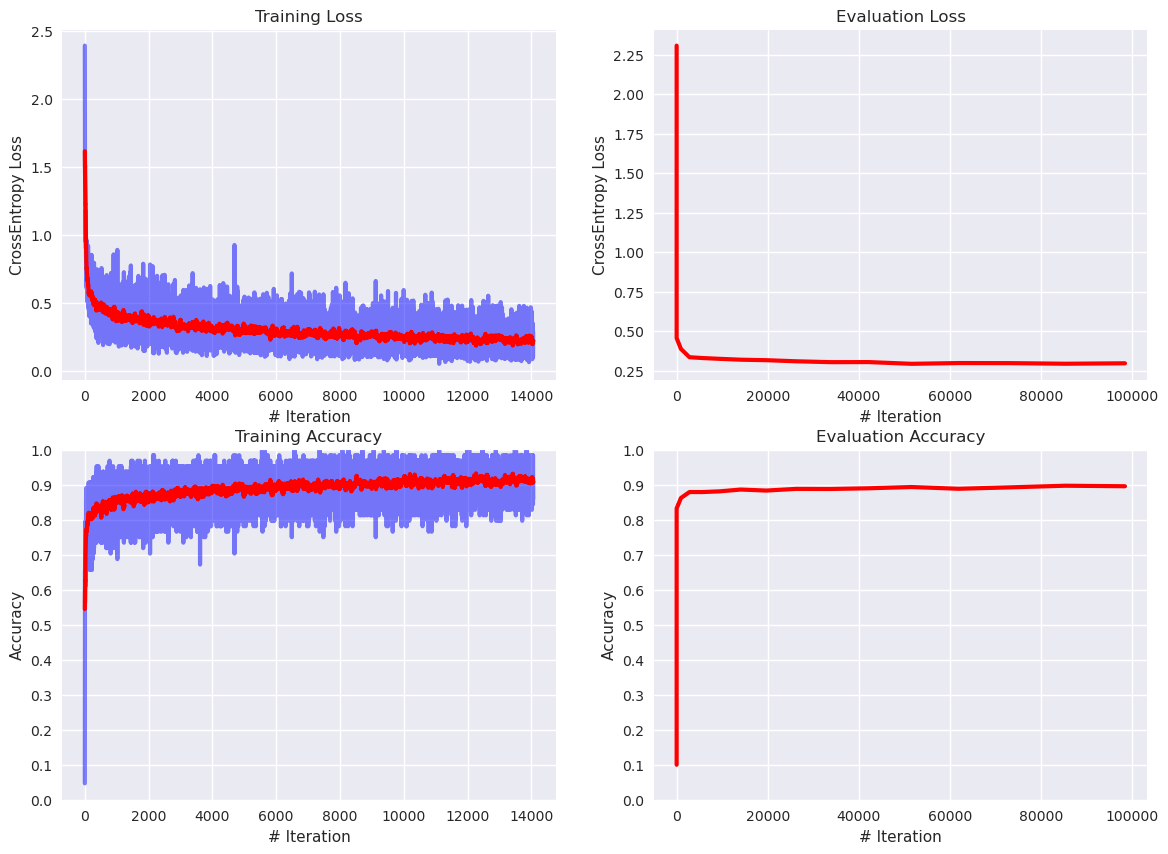

In [247]:
visualize_training_results(mlp_logger, MLP_MODEL_CONFIG)

Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 185.98it/s]


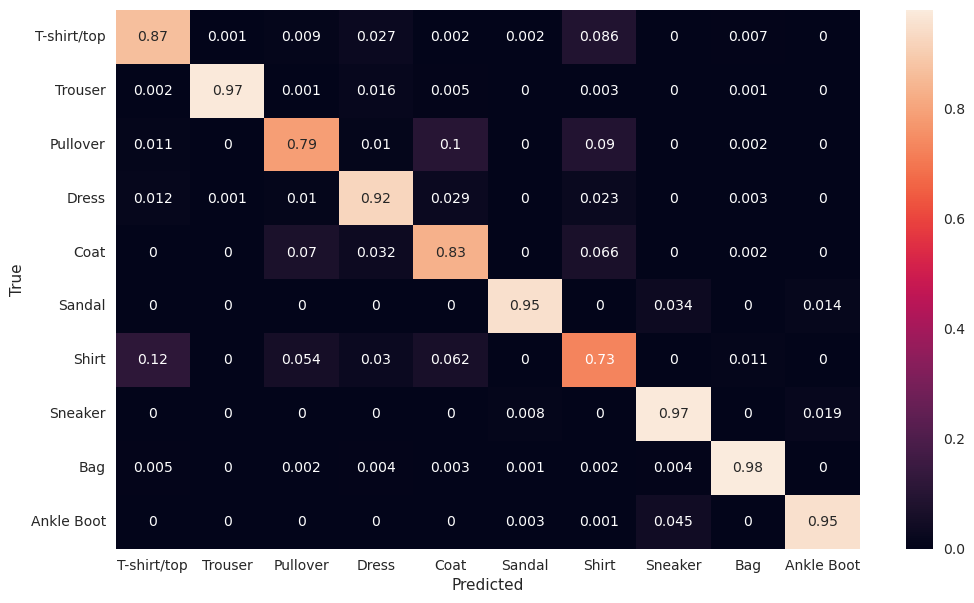

In [248]:
eval_run_config = copy.deepcopy(MLP_MODEL_CONFIG)
eval_run_config['evaluation'] = EVALUATION_CONFIG
evaluation_metrics, _ = run_evaluation(mlp_model, mlp_data_augmentor, mlp_test_loader, eval_run_config, criterion)
visualize_confusion_matrix(evaluation_metrics['confusion_matrix'])

#### Training Results: CNN

The CNN model performs well on the FashionMNIST dataset. It converges slower than the MLP model but achieves a slightly better performance with an accuracy of ~91% on the test dataset. It uses less than half of the parameters than the MLP model and still outperforms it. Only a small fraction of the trainable parameters in the CNN model lie actually in the convolutional layers. This shows the efficiency of convolutional layers to extract a meaningful representation of the 2D vision data that can then be fed to a final (potentially smaller than comparable MLP models) MLP. The model tends to overfit as the accuracy on the training set rises up to ~98%. This could possibly be prevented through more fine-tuning or data augmentation.

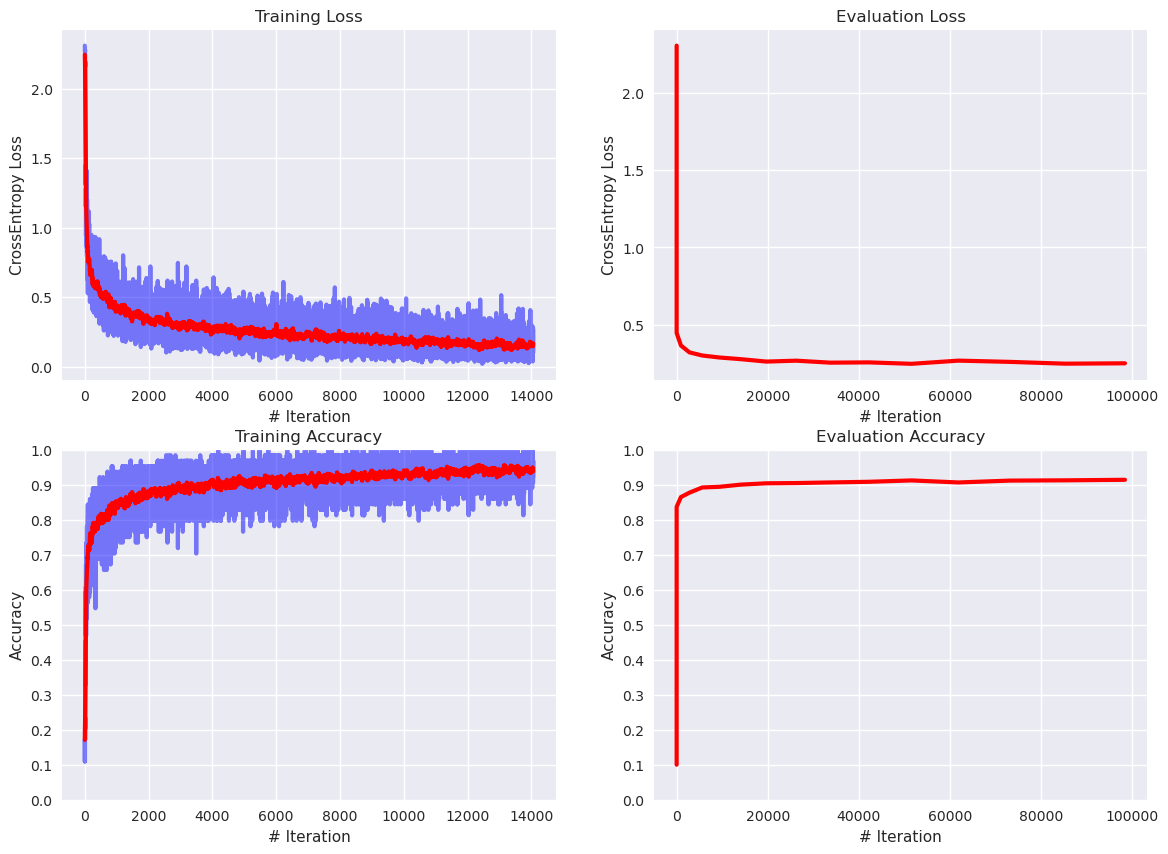

In [249]:
visualize_training_results(cnn_logger, CNN_MODEL_CONFIG)

Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 179.28it/s]


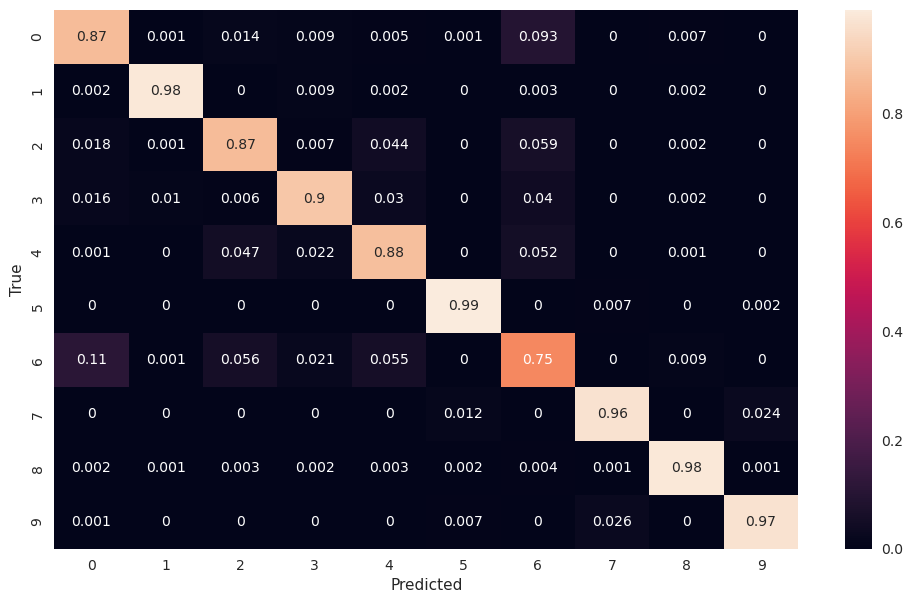

In [250]:
eval_run_config = copy.deepcopy(CNN_MODEL_CONFIG)
eval_run_config['evaluation'] = EVALUATION_CONFIG
evaluation_metrics, _ = run_evaluation(cnn_model, cnn_data_augmentor, cnn_test_loader, eval_run_config, criterion)
visualize_confusion_matrix(evaluation_metrics['confusion_matrix'])

## Task: 2 Kernel Visualizations
The visualizations shows the kernels for a random output channel and the convolved output. If we have multiple input channels we print a subset of the kernels for each input channel.
We see that in the first layer that the model extracts low level features such as edges. Each kernel describes a different extracted feature. For some kernels one could argue that the weights in the kernel emphasize edges as the pixels given the highest weight lie in a single row or column.
In the output images of the first layer one can see different parts of the images highlighted, such as the background edges, or just pixels with a high intensity gradient. In the following layers the resolution gets increasingly reduced. The second layer already outputs a blurred image that is hard to interpret. The last layer outputs high-level features at a low resolution of (3,3) that can then be used by the following fully connected layers to infer about the class of the image. We can conclude that using a convolution neural network we can extract hierarchical features at different resolutions. This representation of the image seems improve the ability of the following fully connected layers to predict a class.

===--- Model Architecture ---===

ConvolutionalNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=576, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)


/tmp/ipykernel_409840/2480880949.py:178: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



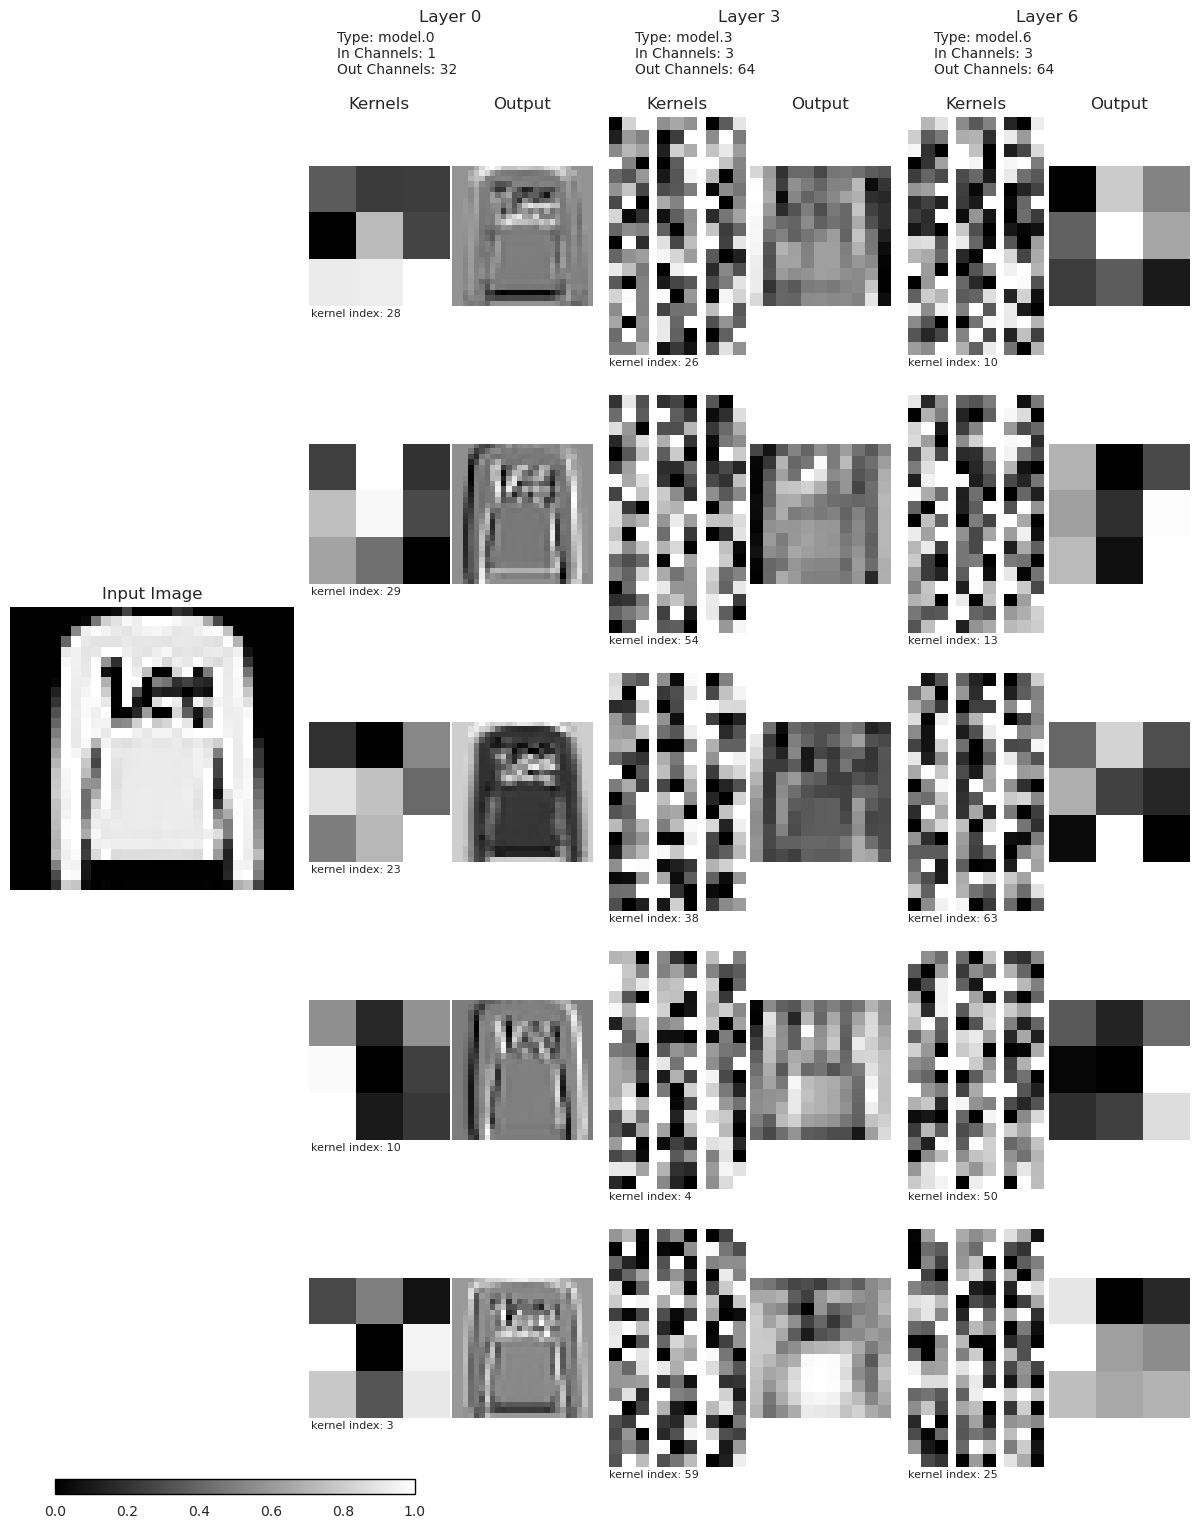

In [251]:

###--- Hyperparameters ---###
NUM_VIS = 1

set_random_seed(22)

# Kernels to be visualized
kernel_vis = ['model.0', 'model.3', 'model.6']
output_vis = ['model.0', 'model.3', 'model.6']

# Module to further inspect the weights and outputs
inspector = InspectorGadgets()

# Define layers to be further inspected
for layer_name, module in cnn_model.named_modules():
    # Save weights for the layers defined in kernel_vis
    if layer_name in kernel_vis:
        inspector.log_weights([module], [layer_name])
    # Save the outputs for the layers defined in output_vis
    if layer_name in output_vis:
        inspector.log_outputs([module], [layer_name])

print(f'===--- Model Architecture ---===\n')
print(cnn_model)

###--- Visualization ---###

for i, (img,label) in enumerate(cnn_test_loader):
    if i==NUM_VIS:
        break
    image_raw, label_raw = torch.clone(img), torch.clone(label)
    img, label = img.to(device), label.to(device)

    img = cnn_data_augmentor(img)

    output = cnn_model(img)


kernels, bias = inspector.get_weights()
kernel_data, bias_data = list(kernels.values()), list(bias.values())
output = inspector.get_output()
output_data = list(output.values())
image_ind = 1
image = image_raw[image_ind].squeeze()
vis_data_kernel = [kernel_data[layer][0].squeeze() for layer in range(len(kernel_data))]
vis_data_outputs = [output_data[layer][0][image_ind] for layer in range(len(kernel_data))]



visualize_convolution(image=image, 
                        kernels=vis_data_kernel, 
                            outputs=vis_data_outputs, 
                                layer_names=kernel_vis, 
                                    num_kernels=5)






## Task 3: Studies on Max. Pooling, Avg. Pooling, Strided Convolutions

Here we compare the influence of using different pooling strategies on models of similar architectures. Additionaly we show the influence of pooling strategies, stride and kernel size on the models performance. In this section we will again re-use the CNN model and adjust it to create a larger and a smaller version to test out.

### Model Architectures

In [38]:
LAYER_ARCHITECTURE_NO_POOLING =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 30976, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]
LAYER_ARCHITECTURE_NO_POOLING_SMALL =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 30976, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_NO_POOLING_LARGE =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            
                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 128, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 128, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 30976, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_MAX =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 576, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_MAX_2 =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 6400, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_MAX_SMALL =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 576, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_MAX_LARGE =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            
                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 128, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 128, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 5184, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]


LAYER_ARCHITECTURE_AVG =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'avgpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'avgpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 576, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

LAYER_ARCHITECTURE_AVG_2 =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'avgpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 6400, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]


LAYER_ARCHITECTURE_AVG_SMALL =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'avgpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 576, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]

### No Pooling

In [253]:
CNN_NO_POOLING_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_NO_POOLING,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': None
                            
                        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
set_random_seed(42)

cnn_np_model, cnn_np_train_loader, cnn_np_test_loader, cnn_np_data_augmentor, cnn_np_logger = train_cnn(CNN_NO_POOLING_MODEL_CONFIG)

Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 147.67it/s]


 accuracy: 0.09094551282051282, eval_loss: 2.30517538694235,

Epoch 1/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 146.91it/s]


accuracy: 0.8828125, eval_loss: 0.33162803718676936, train_loss: 0.1737183779478073, train_accuracy: 0.9375

Epoch 2/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 151.37it/s]


accuracy: 0.9020432692307693, eval_loss: 0.269469385393537, train_loss: 0.19691070914268494, train_accuracy: 0.921875

Epoch 3/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 147.93it/s]


accuracy: 0.9112580128205128, eval_loss: 0.24137164781299922, train_loss: 0.20984143018722534, train_accuracy: 0.921875

Epoch 4/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 152.65it/s]


accuracy: 0.9129607371794872, eval_loss: 0.24077619430728447, train_loss: 0.26502159237861633, train_accuracy: 0.90625

Epoch 5/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 144.85it/s]


accuracy: 0.9140625, eval_loss: 0.24332251027226448, train_loss: 0.24431146681308746, train_accuracy: 0.90625

Epoch 6/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 147.73it/s]


accuracy: 0.9157652243589743, eval_loss: 0.2617022395133972, train_loss: 0.1076371893286705, train_accuracy: 0.96875

Epoch 7/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 152.23it/s]


accuracy: 0.9192708333333334, eval_loss: 0.27780193123870933, train_loss: 0.013879339210689068, train_accuracy: 1.0

Epoch 8/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 152.73it/s]


accuracy: 0.9120592948717948, eval_loss: 0.3247295910349259, train_loss: 0.068748839199543, train_accuracy: 0.96875

Epoch 9/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 151.17it/s]


accuracy: 0.9114583333333334, eval_loss: 0.36299920846254397, train_loss: 0.15682093799114227, train_accuracy: 0.953125

Epoch 10/10


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 152.82it/s]

accuracy: 0.910957532051282, eval_loss: 0.4078189541752904, train_loss: 0.012028202414512634, train_accuracy: 1.0


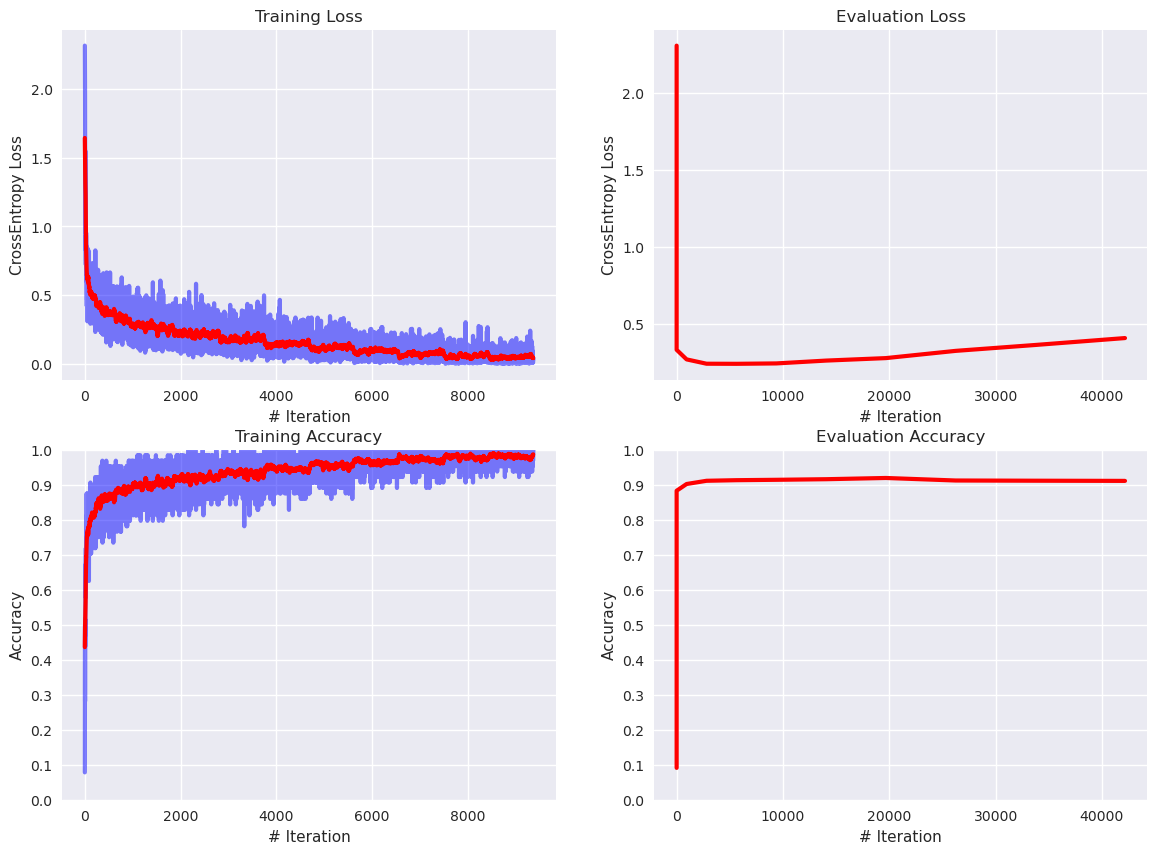

In [254]:
visualize_training_results(cnn_np_logger, CNN_NO_POOLING_MODEL_CONFIG)

### Max Pooling

In [255]:
CNN_MAX_POOLING_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_MAX,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': None
                            
                        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
set_random_seed(42)

cnn_mp_model, cnn_mp_train_loader, cnn_mp_test_loader, cnn_mp_data_augmentor, cnn_mp_logger = train_cnn(CNN_MAX_POOLING_MODEL_CONFIG)

Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 180.74it/s]


 accuracy: 0.10006009615384616, eval_loss: 2.3064472522491064,

Epoch 1/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.51it/s]


accuracy: 0.8363381410256411, eval_loss: 0.45030457182572436, train_loss: 0.4491136372089386, train_accuracy: 0.8125

Epoch 2/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 177.81it/s]


accuracy: 0.8655849358974359, eval_loss: 0.36320162067810696, train_loss: 0.20890143513679504, train_accuracy: 0.921875

Epoch 3/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 178.09it/s]


accuracy: 0.8787059294871795, eval_loss: 0.32134155919536567, train_loss: 0.27670568227767944, train_accuracy: 0.875

Epoch 4/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 178.90it/s]


accuracy: 0.8910256410256411, eval_loss: 0.29850024118637425, train_loss: 0.34868958592414856, train_accuracy: 0.84375

Epoch 5/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 179.71it/s]


accuracy: 0.8927283653846154, eval_loss: 0.2839402629969976, train_loss: 0.36383384466171265, train_accuracy: 0.890625

Epoch 6/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 179.02it/s]


accuracy: 0.9039463141025641, eval_loss: 0.27085918488983923, train_loss: 0.3401242792606354, train_accuracy: 0.859375

Epoch 7/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 171.65it/s]


accuracy: 0.9057491987179487, eval_loss: 0.2629073470448836, train_loss: 0.24064666032791138, train_accuracy: 0.9375

Epoch 8/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 179.08it/s]


accuracy: 0.9056490384615384, eval_loss: 0.26662488205310625, train_loss: 0.20975881814956665, train_accuracy: 0.9375

Epoch 9/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 175.42it/s]


accuracy: 0.9043469551282052, eval_loss: 0.254897378385067, train_loss: 0.10528062283992767, train_accuracy: 0.96875

Epoch 10/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 176.27it/s]

accuracy: 0.9074519230769231, eval_loss: 0.2544490498705552, train_loss: 0.1849443018436432, train_accuracy: 0.921875


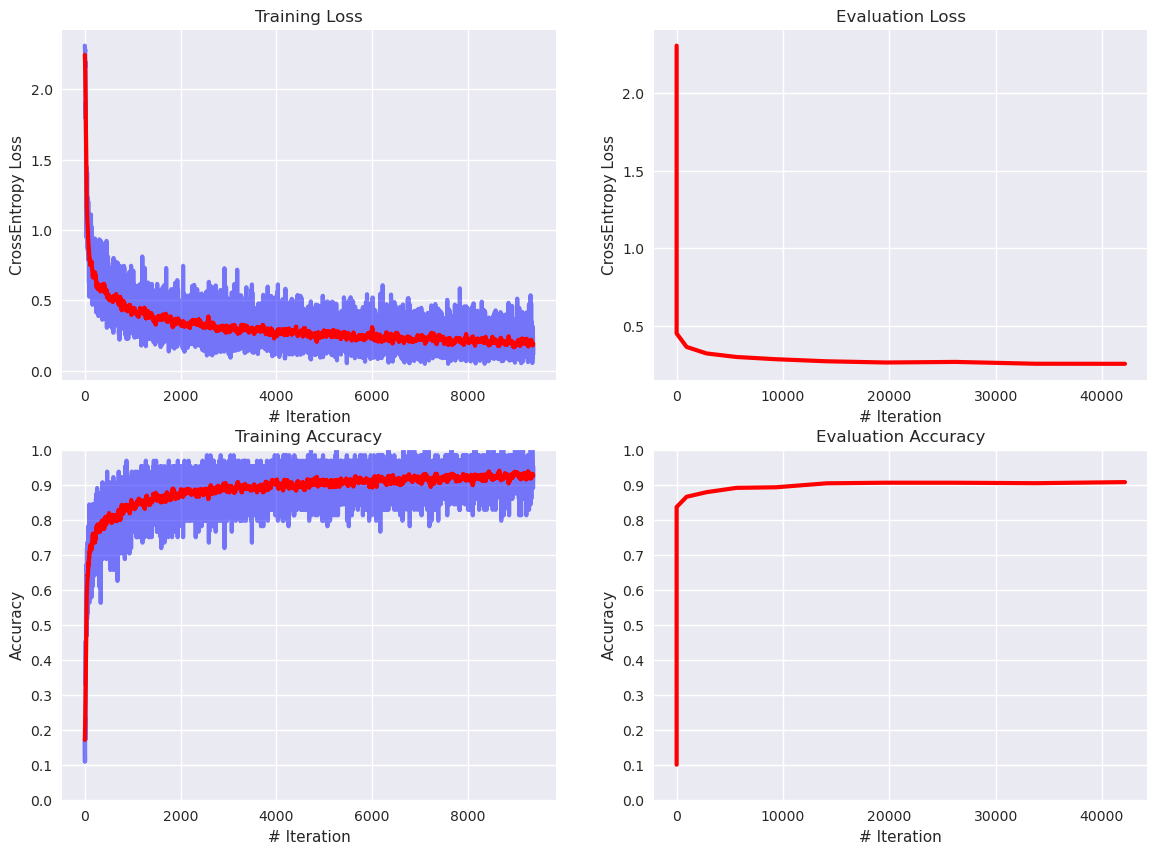

In [256]:
visualize_training_results(cnn_mp_logger, CNN_MAX_POOLING_MODEL_CONFIG)


### Average Pooling

In [257]:
CNN_AVG_POOLING_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_AVG,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 10,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': None
                            
                        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed
set_random_seed(42)

cnn_ap_model, cnn_ap_train_loader, cnn_ap_test_loader, cnn_ap_data_augmentor, cnn_ap_logger = train_cnn(CNN_AVG_POOLING_MODEL_CONFIG)

Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 180.31it/s]


 accuracy: 0.10006009615384616, eval_loss: 2.3061963686576257,

Epoch 1/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 170.30it/s]


accuracy: 0.8157051282051282, eval_loss: 0.4964806250272653, train_loss: 0.5144752860069275, train_accuracy: 0.75

Epoch 2/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 176.63it/s]


accuracy: 0.8489583333333334, eval_loss: 0.41155325879271215, train_loss: 0.2638222277164459, train_accuracy: 0.875

Epoch 3/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 169.10it/s]


accuracy: 0.8704927884615384, eval_loss: 0.35748591856696665, train_loss: 0.34271106123924255, train_accuracy: 0.875

Epoch 4/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 167.99it/s]


accuracy: 0.8808092948717948, eval_loss: 0.333750115468716, train_loss: 0.28729721903800964, train_accuracy: 0.875

Epoch 5/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 172.18it/s]


accuracy: 0.8863181089743589, eval_loss: 0.31054533244325566, train_loss: 0.39349889755249023, train_accuracy: 0.859375

Epoch 6/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 177.51it/s]


accuracy: 0.8930288461538461, eval_loss: 0.29920545640664226, train_loss: 0.3320978879928589, train_accuracy: 0.875

Epoch 7/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 176.44it/s]


accuracy: 0.8943309294871795, eval_loss: 0.28917195208561725, train_loss: 0.29385095834732056, train_accuracy: 0.90625

Epoch 8/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 173.69it/s]


accuracy: 0.9018429487179487, eval_loss: 0.27805186082155275, train_loss: 0.28124159574508667, train_accuracy: 0.875

Epoch 9/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 174.33it/s]


accuracy: 0.9029447115384616, eval_loss: 0.2726153065092288, train_loss: 0.12550577521324158, train_accuracy: 0.953125

Epoch 10/10


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 172.71it/s]

accuracy: 0.9017427884615384, eval_loss: 0.26969922190675366, train_loss: 0.2578720152378082, train_accuracy: 0.921875


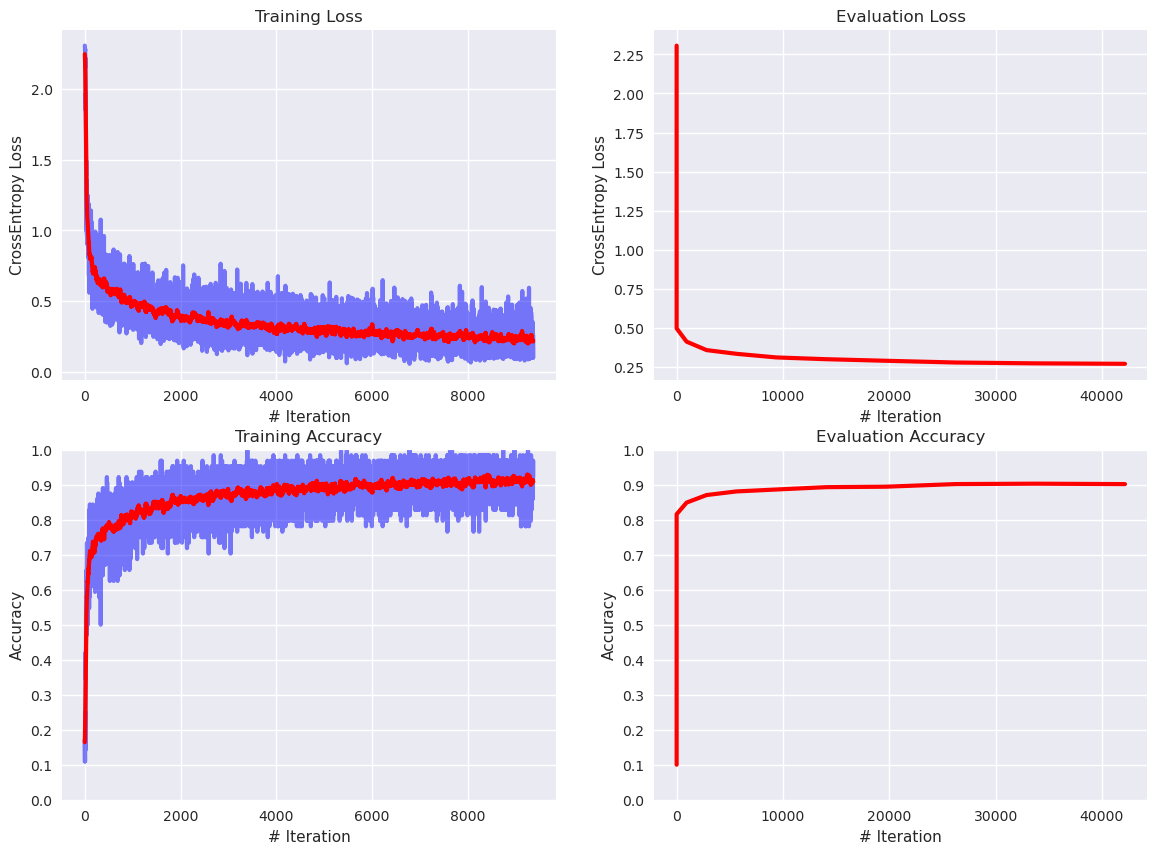

In [258]:
visualize_training_results(cnn_ap_logger, CNN_AVG_POOLING_MODEL_CONFIG)


### Study on Stride and Kernel size


In [47]:
###--- Hyperparameters ---###
OPTIM_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': [],
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 10,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            }
                            
                        }

###--- Objective Function ---###
def objective(trial):
    set_random_seed(42)

    ###--- Sample Model Architecture ---###
    architecture = trial.suggest_categorical('architecture', ['AVG', 'AVG_S', 'MAX','MAX_S','MAX_L', 'NO', 'NO_S', 'NO_L'])
    config = copy.deepcopy(OPTIM_MODEL_CONFIG)

    if architecture == 'AVG':
        layer_architecture = LAYER_ARCHITECTURE_AVG_2
    elif architecture == 'MAX':
        layer_architecture = LAYER_ARCHITECTURE_MAX_2
    elif architecture == 'NO':
        layer_architecture = LAYER_ARCHITECTURE_NO_POOLING
    elif architecture == 'AVG_S':
        layer_architecture = LAYER_ARCHITECTURE_AVG_SMALL
    elif architecture == 'MAX_S':
        layer_architecture = LAYER_ARCHITECTURE_MAX_SMALL
    elif architecture == 'NO_S':
        layer_architecture = LAYER_ARCHITECTURE_NO_POOLING_SMALL
    elif architecture == 'MAX_L':
        layer_architecture = LAYER_ARCHITECTURE_MAX_LARGE
    elif architecture == 'NO_L':
        layer_architecture = LAYER_ARCHITECTURE_NO_POOLING_LARGE
    
    # For each convolutional or max/avg pooling layer sample kernel size, stride or pooling size.
    for i, layer in enumerate(layer_architecture):
        if layer['type'] == 'conv2d':
            kernel_size = trial.suggest_categorical(f'conv2d_{i}_kSize', KERNEL_SIZES)
            stride = trial.suggest_categorical(f'conv2d_{i}_stride', STRIDE)
            layer_architecture[i]['kernel_size'] = (kernel_size, kernel_size)
            layer_architecture[i]['stride'] = (stride, stride)

        if layer['type'] in ['avgpool2d', 'maxpool2d']:
            lType = layer['type']
            pool_size = trial.suggest_categorical(f'{lType}_{i}_kSize', POOLING_STRIDE)
            stride = trial.suggest_categorical(f'{lType}_{i}_stride', POOLING_SIZES)
            layer_architecture[i]['kernel_size'] = (pool_size, pool_size)
            layer_architecture[i]['stride'] = (stride, stride)

        if layer['type']=='linear':
            shape, _ = check_configuration(layer_architecture, i-1, suppress_output=True)
            layer_architecture[i]['in_features'] = shape

    config['layers'] = layer_architecture

    # Check if the model architecture is valid by checking the output dimension of each layer
    # If some input dimensions are messed up, the config is fixed and returned
    model_info, valid = check_configuration(layer_architecture, input_shape=(1,28,28), suppress_output=True, fix=True)
    if valid:
        # Set eventually fixed config
        config['layers'] = model_info[0]
    else:
        return 0
    
    # Train the model according to the config and return the best score (accuracy) achieved
    score = optimize_cnn(config, trial)

    return score

KERNEL_SIZES = [3,5,7]
POOLING_SIZES = [2,3,4]
STRIDE = [1,2]
POOLING_STRIDE = [2,3]

NAME = 'architecture_study_fixed_01'
N_TRIALS = 20


study = optuna.create_study(study_name=NAME,
                                storage=f'sqlite:///{NAME}.db', load_if_exists=True,
                                    direction='maximize',
                                        sampler = optuna.samplers.TPESampler(), 
                                            pruner = optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_TRIALS)

[I 2023-05-02 18:33:48,566] Using an existing study with name 'architecture_study_fixed_01' instead of creating a new one.
[I 2023-05-02 18:33:49,458] Trial 2 finished with value: 0.0 and parameters: {'architecture': 'MAX', 'conv2d_0_kSize': 7, 'conv2d_0_stride': 1, 'conv2d_2_kSize': 7, 'conv2d_2_stride': 1, 'maxpool2d_4_kSize': 3, 'maxpool2d_4_stride': 3, 'conv2d_5_kSize': 7, 'conv2d_5_stride': 1}. Best is trial 0 with value: 0.0.
[I 2023-05-02 18:35:10,005] Trial 3 finished with value: 0.9030448717948718 and parameters: {'architecture': 'NO', 'conv2d_0_kSize': 3, 'conv2d_0_stride': 2, 'conv2d_2_kSize': 7, 'conv2d_2_stride': 2, 'conv2d_4_kSize': 3, 'conv2d_4_stride': 1}. Best is trial 3 with value: 0.9030448717948718.
[I 2023-05-02 18:35:10,754] Trial 4 finished with value: 0.0 and parameters: {'architecture': 'MAX', 'conv2d_0_kSize': 3, 'conv2d_0_stride': 1, 'conv2d_2_kSize': 7, 'conv2d_2_stride': 2, 'maxpool2d_4_kSize': 3, 'maxpool2d_4_stride': 4, 'conv2d_5_kSize': 3, 'conv2d_5_stri

### Evaluation

From the first studies of the pooling layers we can conclude that maximum and average pooling perform similarily well. Pooling layers create spatial invariance by creating a sparse representation of the input data by pooling a reactangular field of pixels to a single pixel in the output space. This also induces some kind of regularization as the number of (potentially unnecessary) information is also reduced. In particular, we can see that the size of the flattened input for the last fully connected layers is much larger for the model without pooling. This model converges faster during training, which I attribute to the additional information, but also tends to overfit fast. Still, all models seem to perform similar on the evaluation set.

#### Outcome of the Hyperparameter Optimization
First a short remark:

One problem of the evaluation of the study is that the optimizer tends to over sample the model architectures without pooling layers. In the trials the pooling size and stride of the pooling layers is optimized. This can lead to cases where the model configuration is not possible due to the output planes being to small (e.g. smaller than the kernel size of the next layer). Trials like this get the feedback 0.0, since the optimized configuration is not possible. Ultimately this leads to the sampler choosing the model architectures with pooling layers less likely.<br />

The best performing model in the studies seems to be the small architecture of the CNN without pooling layers. One reason for this could be that the image size is rather small such that pooling layers decrease the number of features to an extend that results in information loss. A CNN without pooling layers but a larger image descriptor that is fed to the fully connected layers might perform better in this case. In the first convolutional layer a kernel size of three seems to be favorable. In the later larger kernel sizes such as five or seven tend to perform better. For the stride parameter the best value seems to be one, implementing no spatial sparseness in the convolutional filters. With sparse filters the output size is further reduced, creating non-valid model configurations. Creating a sparser representation through pooling layers and larger stride parameter seems to not improve our model. We assume that the input size of the image is too small to effectively implement such strategies to improve the model's performance.<br />

In [58]:
NAME = 'architecture_study_fixed_01'

study = optuna.create_study(study_name=NAME,
                                storage=f'sqlite:///{NAME}.db', load_if_exists=True,
                                    direction='maximize',
                                        sampler = optuna.samplers.TPESampler(), 
                                            pruner = optuna.pruners.MedianPruner())

[I 2023-05-02 19:33:32,114] Using an existing study with name 'architecture_study_fixed_01' instead of creating a new one.


#### Best Model Architecture


In [59]:
best_params = study.best_params
print('===--- Best Hyperparameter ---===\n')
print('\n'.join([f'  {k}: \t{v}' for k, v in best_params.items()]))
fig = optuna.visualization.plot_slice(study, params=['architecture'], target_name='Accuracy')
fig.show()

===--- Best Hyperparameter ---===

  architecture: 	NO_S
  conv2d_0_kSize: 	3
  conv2d_0_stride: 	1
  conv2d_2_kSize: 	5
  conv2d_2_stride: 	1


#### Influence of Stride

From the plots we can conclude that the stride should be 

In [57]:
fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_0_stride'])
fig.show()

fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_2_stride'])
fig.show()

fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_4_stride'])
fig.show()



#### Influence of Kernel Size

In [56]:
fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_0_kSize'])
fig.show()

fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_2_kSize'])
fig.show()

fig = optuna.visualization.plot_contour(study, params=['architecture', 'conv2d_4_kSize'])
fig.show()

## Task 4: Studies on Data Augmentation

### Data Augmentation
Here we just show some examples pre-processing and augmentation steps from the data augmentation module

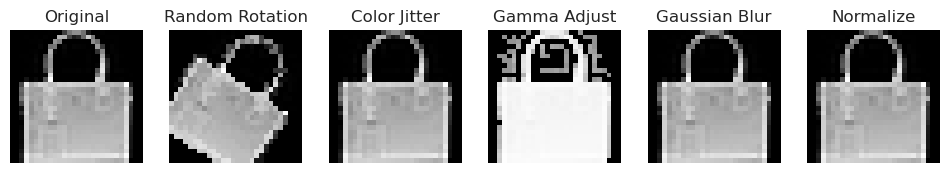

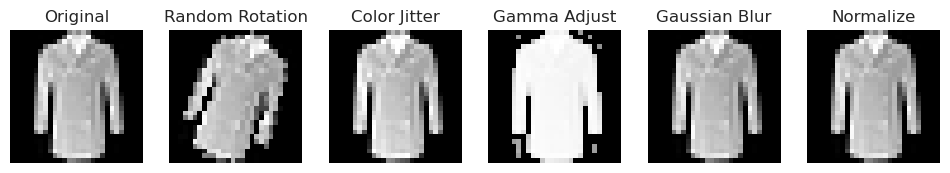

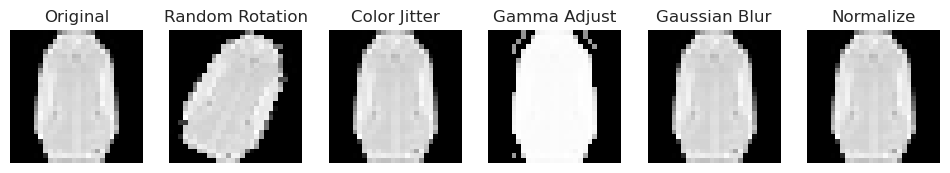

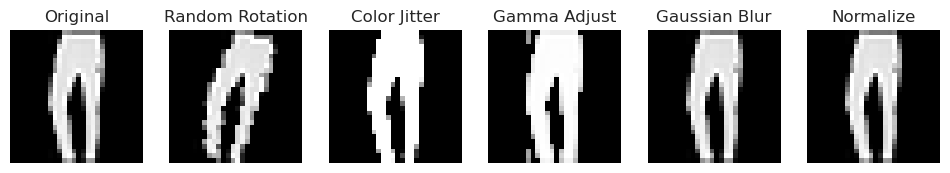

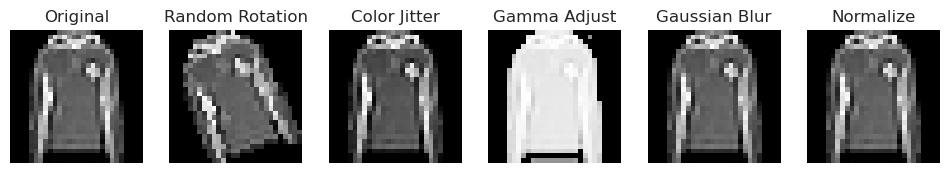

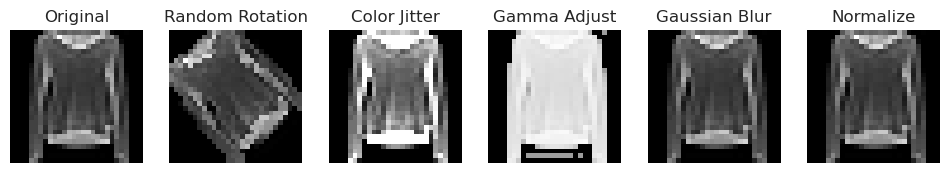

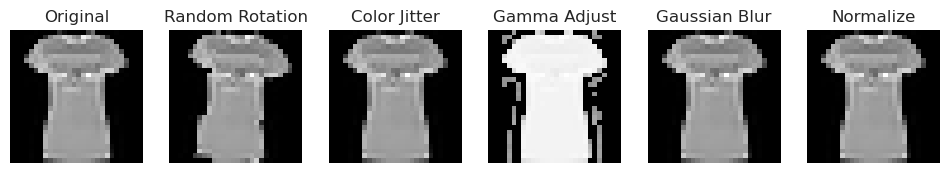

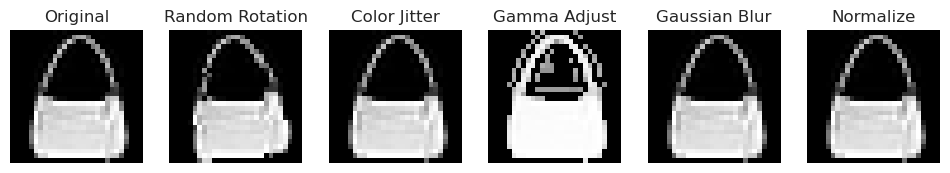

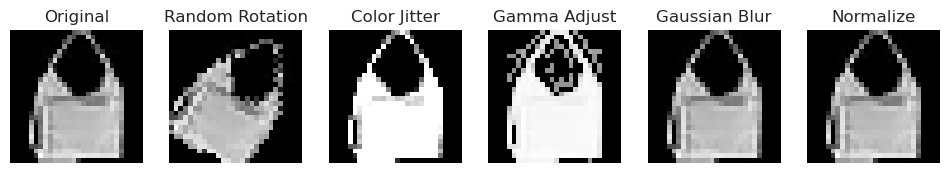

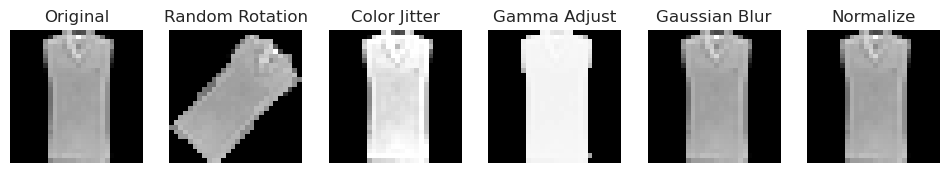

In [261]:
###-- Optimization Parameters --###
RANDOM_ROTATION = False
RANDOM_ROTATION_DEGREES = 180
RANDOM_ROTATION_CONFIG = {'type': 'random_rotation', 'degrees': RANDOM_ROTATION_DEGREES}

ADJUST_GAMMA = False
GAMMA_FACTOR = [0.5,1.5]
ADJUST_GAMMA_CONFIG = {'type': 'adjust_gamma', 'factor': GAMMA_FACTOR}

BLUR = False
BLUR_KERNEL_SIZES = [3,5]
BLUR_SIGMAS = ([0.1,0.1], [2,2])
BLUR_CONFIG = {'type': 'blur', 'kernel_sizes': BLUR_KERNEL_SIZES,'sigmas': BLUR_SIGMAS}

NORMALIZE = False
NORMALIZE_CONFIG = {'type': 'normalize'}

COLOR_JITTER = False
COLOR_JITTER_BRIGHTNESS = [0.0,1.0]
COLOR_JITTER_CONTRAST = [0.0,1.0]
COLOR_JITTER_SATURATION = [0.0,1.0]
COLOR_JITTER_HUE = [0.0,0.5]
COLOR_JITTER_CONFIG = {'type': 'color_jitter', 'brightness': COLOR_JITTER_BRIGHTNESS, 'contrast': COLOR_JITTER_CONTRAST,'saturation': COLOR_JITTER_SATURATION, 'hue': COLOR_JITTER}



NUM_VIS = 10

for i, (img, label) in enumerate(cnn_train_loader):
    if i==NUM_VIS:
        break


    img_1 = ImageDataAugmentor([{'type': 'random_rotation', 'degrees': 45, 'train': True, 'eval': False}])(img)
    img_2 = ImageDataAugmentor([{'type': 'color_jitter', 'degrees': 45, 'brightness': 1.0, 'contrast': 1.0, 'saturation': 1.0, 'hue': 0.5, 'train': True, 'eval': False}])(img)
    img_3 = ImageDataAugmentor([{'type': 'adjust_gamma', 'factor': 0.1, 'train': True, 'eval': False}])(img)
    img_4 = ImageDataAugmentor([{'type': 'blur', 'kernel_sizes': 3,'sigmas': (0.1, 2.0)}])(img)
    img_5 = ImageDataAugmentor([{'type': 'normalize',  'train': True, 'eval': False}])(img)

    img, img_1, img_2, img_3, img_4, img_5 = img[0].squeeze(), img_1[0].squeeze(), img_2[0].squeeze(), img_3[0].squeeze(), img_4[0].squeeze(), img_5[0].squeeze()
    fig, ax = plt.subplots(1,6, figsize=(12,4))
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original')

    ax[1].imshow(img_1, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Random Rotation')

    ax[2].imshow(img_2, cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Color Jitter')

    ax[3].imshow(img_3, cmap='gray')
    ax[3].axis('off')
    ax[3].set_title('Gamma Adjust')

    ax[4].imshow(img_4, cmap='gray')
    ax[4].axis('off')
    ax[4].set_title('Gaussian Blur')

    ax[5].imshow(img_5, cmap='gray')
    ax[5].axis('off')
    ax[5].set_title('Normalize')


### Study

In [61]:
###--- Hyperparameters ---###

LAYER_ARCHITECTURE_OPTIM =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.1},
                            {'type': 'linear', 'in_features': 6400, 'out_features': 128},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]


OPTIM_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_OPTIM,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 10,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': None
                        }

In [62]:
###-- Optimization Parameters --###
RANDOM_ROTATION = True
RANDOM_ROTATION_DEGREES = [0, 180]
RANDOM_ROTATION_CONFIG = {'type': 'random_rotation', 'degrees': RANDOM_ROTATION_DEGREES}

ADJUST_GAMMA = False
GAMMA_FACTOR = [0.5,1.5]
ADJUST_GAMMA_CONFIG = {'type': 'adjust_gamma', 'factor': GAMMA_FACTOR}

BLUR = True
BLUR_KERNEL_SIZES = [3,5]
BLUR_SIGMAS = ([0.1,0.1], [2,2])
BLUR_CONFIG = {'type': 'blur', 'kernel_sizes': BLUR_KERNEL_SIZES,'sigmas': BLUR_SIGMAS}

NORMALIZE = True
NORMALIZE_CONFIG = {'type': 'normalize'}

COLOR_JITTER = True
COLOR_JITTER_BRIGHTNESS = [0.0,1.0]
COLOR_JITTER_CONTRAST = [0.0,1.0]
COLOR_JITTER_SATURATION = [0.0,1.0]
COLOR_JITTER_HUE = [0.0,0.5]
COLOR_JITTER_CONFIG = {'type': 'color_jitter', 'brightness': COLOR_JITTER_BRIGHTNESS, 'contrast': COLOR_JITTER_CONTRAST,'saturation': COLOR_JITTER_SATURATION, 'hue': COLOR_JITTER}

def augmentation_objective(trial):
    set_random_seed(42)

    def _set_config():
        augmentation_config = []

        if RANDOM_ROTATION:
            if trial.suggest_categorical('random_rotation', [True,False]):
                random_degrees = trial.suggest_int('random_rotation_degrees', RANDOM_ROTATION_DEGREES[0], RANDOM_ROTATION_DEGREES[1])
                augmentation_config.append({'type': 'random_rotation', 'degrees': random_degrees, 'train': True, 'eval': False})
        if ADJUST_GAMMA:
            if trial.suggest_categorical('adjust_gamma', [True,False]):
                factor = trial.suggest_float('adjust_gamma_factor', GAMMA_FACTOR[0], GAMMA_FACTOR[1])
                augmentation_config.append({'type': 'adjust_gamma', 'factor': factor, 'train': True, 'eval': True})
        if COLOR_JITTER:
            if trial.suggest_categorical('color_jitter', [True,False]):
                brightness = trial.suggest_float('color_jitter_brightness', COLOR_JITTER_BRIGHTNESS[0], COLOR_JITTER_BRIGHTNESS[1])
                contrast = trial.suggest_float('color_jitter_contrast', COLOR_JITTER_CONTRAST[0], COLOR_JITTER_CONTRAST[1])
                saturation = trial.suggest_float('color_jitter_saturation', COLOR_JITTER_SATURATION[0], COLOR_JITTER_SATURATION[1])
                hue = trial.suggest_float('color_jitter_hue', COLOR_JITTER_HUE[0], COLOR_JITTER_HUE[1])
                augmentation_config.append({'type': 'color_jitter', 'brightness': brightness, 'contrast': contrast, 'saturation': saturation, 'hue': hue, 'train': True, 'eval': False})
        if BLUR:
            if trial.suggest_categorical('blur', [True,False]):
                kernel_sizes = trial.suggest_categorical('blur_kernel_sizes', BLUR_KERNEL_SIZES)
                sigma_1 = trial.suggest_int('blur_sigma_1', BLUR_SIGMAS[0][0], BLUR_SIGMAS[0][1])
                sigma_2 = trial.suggest_int('blur_sigma_2', BLUR_SIGMAS[1][0], BLUR_SIGMAS[1][1])
                augmentation_config.append({'type': 'blur', 'kernel_sizes': kernel_sizes,'sigmas': (sigma_1,sigma_2), 'train': True, 'eval': False})
        if NORMALIZE:
            if trial.suggest_categorical('normalize', [True,False]):
                augmentation_config.append({'type': 'normalize', 'train': True, 'eval': True})

        return augmentation_config
            

    augmentation_config = _set_config()

    model_config = OPTIM_MODEL_CONFIG

    model_config['pre_processing'] = augmentation_config

    # Train the model according to the config and return the best score (accuracy) achieved
    score = optimize_cnn(model_config, trial)

    return score

    

NAME = 'augmentation_study_04'
N_TRIALS = 1


study = optuna.create_study(study_name=NAME,
                                storage=f'sqlite:///{NAME}.db', load_if_exists=True,
                                    direction='maximize',
                                        sampler = optuna.samplers.TPESampler(), 
                                            pruner = optuna.pruners.MedianPruner())

study.optimize(augmentation_objective, n_trials=N_TRIALS)





[I 2023-05-02 19:37:17,281] Using an existing study with name 'augmentation_study_04' instead of creating a new one.
[I 2023-05-02 19:39:13,683] Trial 44 finished with value: 0.9235777243589743 and parameters: {'random_rotation': False, 'color_jitter': False, 'blur': False, 'normalize': True}. Best is trial 44 with value: 0.9235777243589743.


### Evaluation

The evaluation of the different data augmentation techniques shows that normalization of the image seems to improve results. Other data augmentation techniques such as random rotations, blur or color jitter do not seem to improve the results. From the importance plot we can conclude that it is important to not take random rotation in. It seems to make the task more difficult instead of providing preventing the model from overfitting. One problem here is that the augmentation parameters of the different processing steps themselves  are part of the optimization. This might lead to the augmentation steps being tested with non-optimized parameters. Another reason for the data augmentation not to improve the results might be the low resolution of the images, such that editing the images has no or a large effect that makes the image unrecognizable.

In [63]:
NAME = 'augmentation_study_04'

study = optuna.create_study(study_name=NAME,
                                storage=f'sqlite:///{NAME}.db', load_if_exists=True,
                                    direction='maximize',
                                        sampler = optuna.samplers.TPESampler(), 
                                            pruner = optuna.pruners.MedianPruner())

[I 2023-05-02 19:39:21,322] Using an existing study with name 'augmentation_study_04' instead of creating a new one.


In [71]:
best_params = study.best_params
print('===--- Best Hyperparameter ---===\n')
print('\n'.join([f'  {k}: \t{v}' for k, v in best_params.items()]))


===--- Best Hyperparameter ---===

  blur: 	False
  color_jitter: 	False
  normalize: 	True
  random_rotation: 	False


In [95]:
fig = optuna.visualization.plot_slice(study, params=['blur', 'color_jitter', 'normalize', 'random_rotation'], target_name='Accuracy')
fig.show()

In [65]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [67]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=['blur', 'color_jitter', 'normalize', 'random_rotation'])
fig.show()

## Bonus Task: Scheduler

In this last section, we take the knowledge from the previous task and our custom scheduler to build the best possible model. We reduced the number of pooling layers to only a single layer in the middle. We included the normalization in the pre processing step of the images. To prevent overfitting we included dropout and batch normalization layers between the fully connected layers. These seem to improve our models and make the converge faster. We were able to improve our accuracy a little bit to ~93%.

The scheduler module that we use to implement the learning rate scheduler is located at "Scripts/Functions" --> "Training". For convenience the code is shown below.

```python
class Scheduler:
    def __init__(self, optimizer, config):
        self.optimizer = optimizer
        self.scheduler_config = config
        self._init_scheduler()
    
    def step(self, step: int):
        learning_rate = self.schedule_step(step)
        self.set_learning_rate(learning_rate)


    def set_learning_rate(self, learning_rate):
        for g in self.optimizer.param_groups:
            g['lr'] = learning_rate
        
    def _init_scheduler(self):
        if self.scheduler_config['type']=='warmup_cosine_decay':
            self.schedule_step = self.warmup_cosine_decay
            self.warmup_steps = self.scheduler_config['warmup_steps']
            self.base_lr = self.scheduler_config['learning_rate']
            self.num_iterations = self.scheduler_config['num_iterations']

    def warmup_cosine_decay(self, step):
        """
            Custom learning rate scheduler. In the first warmup_steps steps the learning rate is linearly increased.
            After the warm-up the learning rate cosine decays down to 0 over the course of a single epoch.
        
        """
        warmup_factor = min(step, self.warmup_steps) / self.warmup_steps
        decay_step = max(step - self.warmup_steps, 0) / (self.num_iterations- self.warmup_steps)
        return self.base_lr * warmup_factor * (1 + np.cos(decay_step * np.pi)) / 2
```

In [90]:
###--- Hyperparameters ---###

LAYER_ARCHITECTURE_SCHEDULE =  [
                            {'type': 'conv2d', 'in_channels': 1, 'out_channels': 32, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},

                            {'type': 'conv2d', 'in_channels': 32, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'relu'},
                            {'type': 'maxpool2d', 'kernel_size': (2,2), 'stride': (2,2)},

                            {'type': 'conv2d', 'in_channels': 64, 'out_channels': 64, 'kernel_size': (3,3), 'stride': (1,1)},
                            {'type': 'batchnorm2d', 'num_features': 64, 'eps':1e-05, 'momentum': 0.1},
                            {'type': 'relu'},

                            {'type': 'flatten'},
                            {'type': 'dropout', 'prob': 0.3},
                            {'type': 'linear', 'in_features': 6400, 'out_features': 128},
                            {'type': 'batchnorm1d', 'num_features': 128, 'eps':1e-05, 'momentum': 0.1},
                            {'type': 'relu'},
                            {'type': 'dropout', 'prob': 0.2},
                            {'type': 'linear', 'in_features': 128, 'out_features': 64},
                            {'type': 'batchnorm1d', 'num_features': 64, 'eps':1e-05, 'momentum': 0.1},
                            {'type': 'relu'},
                            {'type': 'linear', 'in_features': 64, 'out_features': 10},

                        ]


SCHEDULE_MODEL_CONFIG =  {
                            'input_dim': 1024,
                            'layers': LAYER_ARCHITECTURE_SCHEDULE,
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': [{'type': 'normalize', 'train': True, 'eval': True}],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            },
                            'scheduler': {'type': 'warmup_cosine_decay', 'learning_rate': 0.0005, 'warmup_steps':20, 'num_iterations': 937}
                            
                        }

In [91]:
# Set random seed
set_random_seed(42)

schedule_base_model, schedule_base_train_loader, schedule_base_test_loader, schedule_base_data_augmentor, schedule_base_logger = train_cnn(SCHEDULE_MODEL_CONFIG)

Initial Evluation


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 159.30it/s]


 accuracy: 0.14493189102564102, eval_loss: 2.305581267063434,

Epoch 1/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 156.94it/s]


accuracy: 0.9014423076923077, eval_loss: 0.3001689962469615, train_loss: 0.2689782381057739, train_accuracy: 0.9375

Epoch 2/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 157.40it/s]


accuracy: 0.9128605769230769, eval_loss: 0.24749894139285272, train_loss: 0.15825195610523224, train_accuracy: 0.953125

Epoch 3/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 163.03it/s]


accuracy: 0.9177684294871795, eval_loss: 0.22834864831887758, train_loss: 0.3615745007991791, train_accuracy: 0.890625

Epoch 4/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 163.74it/s]


accuracy: 0.9219751602564102, eval_loss: 0.21456494798453954, train_loss: 0.20099472999572754, train_accuracy: 0.953125

Epoch 5/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 161.43it/s]


accuracy: 0.9251802884615384, eval_loss: 0.2071135629159518, train_loss: 0.33123070001602173, train_accuracy: 0.890625

Epoch 6/15


Evaluation:: 100%|██████████| 156/156 [00:01<00:00, 145.21it/s]


accuracy: 0.9264823717948718, eval_loss: 0.20505625515794143, train_loss: 0.1223650574684143, train_accuracy: 0.953125

Epoch 7/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 161.99it/s]


accuracy: 0.9291866987179487, eval_loss: 0.19975941107632258, train_loss: 0.10523529350757599, train_accuracy: 0.953125

Epoch 8/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 165.07it/s]


accuracy: 0.9306891025641025, eval_loss: 0.1939302266169435, train_loss: 0.2680457532405853, train_accuracy: 0.90625

Epoch 9/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 158.44it/s]


accuracy: 0.9330929487179487, eval_loss: 0.1916370902162714, train_loss: 0.15121503174304962, train_accuracy: 0.9375

Epoch 10/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 163.33it/s]


accuracy: 0.9316907051282052, eval_loss: 0.19211434926360083, train_loss: 0.05140350013971329, train_accuracy: 0.984375

Epoch 11/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 156.53it/s]


accuracy: 0.9305889423076923, eval_loss: 0.19152558079132667, train_loss: 0.21373821794986725, train_accuracy: 0.90625

Epoch 12/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 156.42it/s]


accuracy: 0.9340945512820513, eval_loss: 0.19188030374546847, train_loss: 0.07684297859668732, train_accuracy: 0.984375

Epoch 13/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 162.60it/s]


accuracy: 0.9349959935897436, eval_loss: 0.18985674035950348, train_loss: 0.16950659453868866, train_accuracy: 0.90625

Epoch 14/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 164.94it/s]


accuracy: 0.9369991987179487, eval_loss: 0.18805504418336427, train_loss: 0.14993606507778168, train_accuracy: 0.921875

Epoch 15/15


Evaluation:: 100%|██████████| 156/156 [00:00<00:00, 158.41it/s]

accuracy: 0.9372996794871795, eval_loss: 0.18897265115848336, train_loss: 0.11706586927175522, train_accuracy: 0.984375


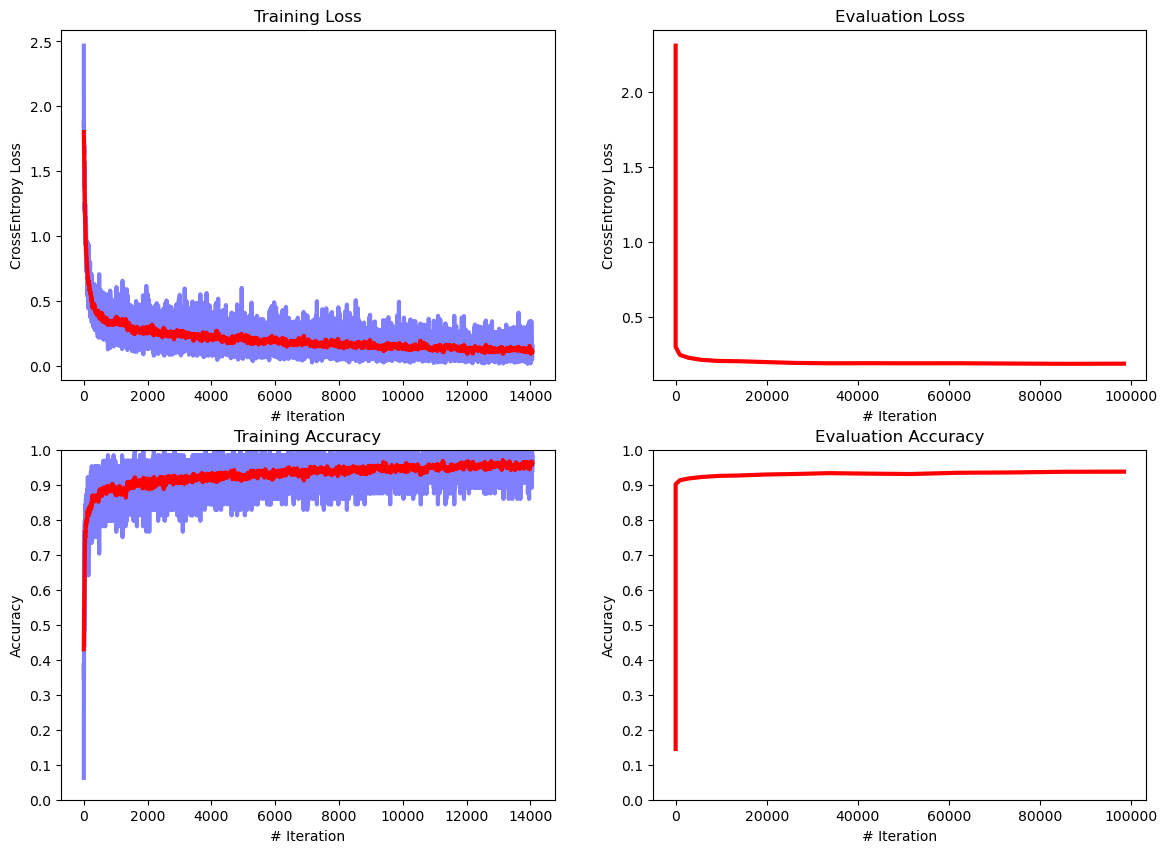

In [94]:
visualize_training_results(schedule_base_logger, SCHEDULE_MODEL_CONFIG)